In [319]:
import pandas as pd
import numpy as np
import math
# Tensorflow
import tensorflow as tf
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import string
import keras

# Imblearn
# pip install imblearn
!pip3 install imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# the following installations are required
# !pip3 install textblob
# !pip3 install spacytextblob
# !pip3 install textblob
# !pip3 install functools
# !pip3 install keras

# python -m pip install textblob
# python -m textblob.download_corpora
# python -m spacy download en_core_web_sm
# pip install spacytextblob
# pip install -U textblob
# python -m textblob.download_corpora
# pip install nlpaug
from spacytextblob.spacytextblob import SpacyTextBlob
from textblob import TextBlob
from functools import reduce
# import nlpaug.augmenter.word as naw

# Setting random seed for reproducibility
randomseed=1
from numpy.random import seed
seed(randomseed)
from tensorflow.random import set_seed
set_seed(randomseed)

# scikit learn
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer, roc_auc_score, plot_roc_curve, roc_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, cross_val_score # K-fold cross validation to be performed for hyperparameter tuning
# import libraries required for lemmatization and for stopwords removal
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize


# import models required
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.naive_bayes import MultinomialNB #  is suitable for classification with discrete features (e.g., word counts for text classification).

# Simple NN
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy, BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from tensorflow.keras.regularizers import l2



# Setting filename for output csv file
filename = 'A0155664X.csv'

  Using cached functools-0.5.tar.gz (4.9 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for functools
Failed to build functools
  Running setup.py install for functools: started
  Running setup.py install for functools: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [1 lines of output]
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for functools
  error: subprocess-exited-with-error
  
  Running setup.py install for functools did not run successfully.
  exit code: 1
  
  [3 lines of output]
  C:\Users\Gary2\anaconda3\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
    warnings.warn(
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  [end of output]
  
  note: This

# Define all our required functions for training, predicting, and generating result file. Also define a function for plotting graphs and ROC curve.

In [2]:
# Define a function to take a training dataframe and output the sentences and the corresponding labels
def get_sentences_and_label(traindf):
    sentences = traindf['Text']
    labels = traindf['Verdict']
    return sentences, labels


In [3]:
# Define a function to open the test set file and return the test sentences from 'Text' to be preprocessed/utilized:
def open_testfile_and_return_sentences():
    df = pd.read_csv('test.csv')
    test_sentences = df['Text']
    return test_sentences

# Define a function to open the test set file and return the test sentences from 'Text' to be preprocessed/utilized:
# performs additional case folding
def open_testfile_and_return_sentences_casefold():
    df = pd.read_csv('test.csv')
    df['Text'] = df['Text'].astype('string')
    df['Text']=df['Text'].map(str.lower)
    test_sentences = df['Text']
    return test_sentences

# Performs casefolding on test dataframe
def casefold_df(df):
    df['Text'] = df['Text'].astype('string')
    df['Text'] = df['Text'].map(str.lower)
    return df

# Define a function that retrieves sentences from test dataframe and returns that Series.
def get_sentences_from_df(df):
    return df['Text']

In [4]:
def score_model(model, Xtest, ytest):
    """
    Takes in a model and test sets from X and y, and returns a dictionary
    containing the score metrics of the trained model.
    """
    # get ypred from model
    ypred = model.predict(Xtest)
    model_baseline = 1 - np.mean(ytest)
    model_f1score = f1_score(y_true=ytest, y_pred=ypred, average='micro')
    print(f"Model test baseline: {model_baseline:.3f}")
    print(f"Model test F1-score: {model_f1score:.3f}")
    result_dict = {
        'baseline': model_baseline,
        'f1score': model_f1score,
    }
    return result_dict

In [5]:
# Write a function to deal with the dataframe and predict the outcome
def predict():
    pass

# write a function that generally takes in test dataframe and generates the verdict column in a new .csv file
def generate_result(test, y_pred, filename):
    """generate csv file based on the y_pred"""
    # test is already the dataframe that will open the file
    test['Verdict'] = pd.Series(y_pred)
    test_output = test.drop(columns=['Text']) # drop the Text column
    # Our final output file should have sentence_id, and verdict only
    test_output.to_csv(filename,index=False)

In [6]:
# Define the necessary dataframes to be used.
test_df = pd.read_csv('test.csv')
df = pd.read_csv('train.csv') # df forms our training dataset
df_original = df.copy()

# Analyze our dataset of statements, there are a total of 22501 statements with their verdicts

Dataset Description
The task is to do a mini-research for solving a fact-checking task. In this fact-checking task, you need to classify whether a text is an important fact (labeled as 1), an unimportant statement (labeled as 0), or a non-factual statement (labeled as -1).

train.csv contains 22,501 rows, where each row has three columns:

- Sentence_id: a positive integer that represents the sentence identifier
- Text: the raw text to be verified
- Verdict: an integer number between [-1, 0, 1] represent the label of the corresponding text.
- - -1 means the text is a non-factual statement
- - 0 means the text is an unimportant statement
- - 1 means the text is an important fact
- test.csv contains 1,032 rows, where each row has 2 columns, same as the train.csv but without the Verdict column.

In [7]:
len(df)

df.isnull().sum() # Check for null values

Sentence_id    0
Text           0
Verdict        0
dtype: int64

## EDA: Checking for imbalanced training dataset

Text(0.5, 1.0, 'Count/Percentage of each class of statements')

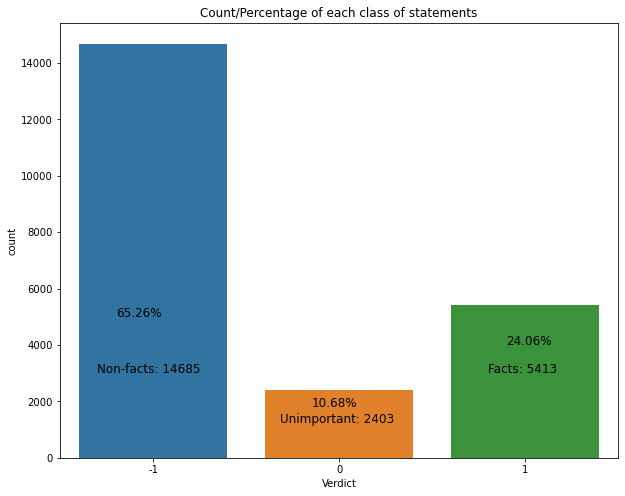

In [8]:
non_fact_statements = df.loc[df['Verdict'] == -1]
unimportant_statements = df.loc[df['Verdict'] == 0]
fact_statements = df.loc[df['Verdict'] == 1]

# Percentage of each class
non_fact_percent = round(len(non_fact_statements)/len(df)*100,2)
unimportant_percent = round(len(unimportant_statements)/len(df)*100,2)
fact_percent = round(len(fact_statements)/len(df)*100,2)


fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x='Verdict', data=df)
plt.annotate(f'Non-facts: {len(non_fact_statements)}', 
             xy=(-0.3, 3000), # xy = (x dist from 0, y dist from 0)
            size=12)

plt.annotate(f'Unimportant: {len(unimportant_statements)}', 
             xy=(0.68, 1250), # xy = (x dist from 0, y dist from 0)
            size=12)
plt.annotate(f'Facts: {len(fact_statements)}', 
             xy=(1.8, 3000), # xy = (x dist from 0, y dist from 0)
            size=12)


plt.annotate(f'{non_fact_percent}%', xy=(-0.2, 5000),size=12)
plt.annotate(f'{fact_percent}%', xy=(1.9, 4000),size=12)
plt.annotate(f'{unimportant_percent}%', xy=(0.85, 1800),size=12)
ax.set_title('Count/Percentage of each class of statements')

## From the graph countplot shown above, we can see that there is class imbalance, whereby 65.26% of the training data belonging to label -1, and 24.06% in label 1 and finally, 10.68% in label 0.

- Hence, in multi-class classification setup for evaluation of our baseline models/models to be used, micro-average calculation will be preferred. A micro-average computation will aggregate the cributions of all classes to compute the average metric. Since there is class imbalance, micro-average is preferable. (Link: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/24051#24051)

- From sklearn f1_score documentation --> 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.

- Another possible metric for evaluation could be to use 'weighted', which is essentially another way to compute micro-average

# Now, we proceed to perform preprocessing & feature engineering on our text data

- Preprocessing required - lowercase --> tokenize --> lemmatize --> remove stopwords --> tfidf
- Feature engineering required - TBD

In [9]:
# Convert all to lowercase in our 'Text' column by using map & lower function
df['Text']=df['Text'].map(str.lower)

# Make use of a baseline MultinomialNB classifier to check if our preprocessing steps aid in our predictions, to decide whether we want to move forward with them

In [10]:
sentences , labels = get_sentences_and_label(df)

As shown above, we manage to obtain a poor f1-score for unimportant statements, but the f1 score on holdout test set is 72.2%.

# Try Naive Bayes Baseline Model on unprocessed data
1. Without normalization
2. With normalization (MinMaxScaler)

Use techniques of tfidf and countvec to check the results for different baseline models
1. TfidfVectorizer
2. CountVectorizer

## Test NB (tfidf) results w/o using MinMaxScaler() on original dataset

In [11]:
# tfidf_vectorizer_full = TfidfVectorizer(ngram_range=(1,1)) # considers unigrams only, for baseline model


# # Train final model on full dataset which is sentences
# X_train_tfidf_full = tfidf_vectorizer_full.fit_transform(sentences) # perform fit_transform

# # Train multinomialNB classifier baseline with original dataset
# mnb_classifier_full = MultinomialNB().fit(X_train_tfidf_full, labels)

In [13]:
# # load in the test.csv data and do prediction, without preprocessing the test sentences
# X_test_full = open_testfile_and_return_sentences()


# # Test classifier
# X_test_tfidf_full = tfidf_vectorizer_full.transform(X_test_full)

# y_pred_full = mnb_classifier_full.predict(X_test_tfidf_full)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)


### From kaggle, the full dataset on baseline model with Naive Bayes using tf-idf led to f1_score of 0.52517. Let us check if normalization of data will help:

## Test NB (tfidf) results by using MinMaxScaler() on original dataset and see if it improves the result

In [14]:
# tfidf_vectorizer_full = TfidfVectorizer(ngram_range=(1,1)) # considers unigrams only, for baseline model

# # Train model on full training which is preprocessed
# X_train_tfidf_full = tfidf_vectorizer_full.fit_transform(sentences) # perform fit_transform

# # load in the test.csv data and do prediction, with casefolding now, since we also casefold in our train data.
# X_test_full = open_testfile_and_return_sentences_casefold()

# # Test classifier
# X_test_tfidf_full = tfidf_vectorizer_full.transform(X_test_full)

# sc = MinMaxScaler() # Define MinMaxScaler for normalization of features
# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train_tfidf_full.toarray())
# X_test_scaled = sc.transform(X_test_tfidf_full.toarray())


# # Train multinomialNB classifier baseline with original dataset
# mnb_classifier_full = MultinomialNB().fit(X_train_scaled, labels)


# y_pred_full = mnb_classifier_full.predict(X_test_scaled)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)


### From results from kaggle, baseline NB (tfidf) with full unprocessed data using MinMaxScaler resulted in a f1_score of 0.76522, hence showing that normalization helps with test f1 score from 0.526517

## Test NB (countvec) results w/o using MinMaxScaler() on original dataset

In [15]:
# count_vectorizer_full = CountVectorizer()

# # Train final model on full dataset whcih is sentencs
# X_train_countvec_full = count_vectorizer_full.fit_transform(sentences)

# # Train multinomialNB classifier with original daaset
# mnb_classifier_full = MultinomialNB().fit(X_train_countvec_full, labels)

In [16]:
# # load in the test.csv data and do prediction, without preprocessing the test sentences
# X_test_full = open_testfile_and_return_sentences()

In [17]:
# # Test classifier
# X_test_countvec_full = count_vectorizer_full.transform(X_test_full)

# y_pred_full = mnb_classifier_full.predict(X_test_countvec_full)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)

## From kaggle, the full dataset on baseline model with Naive Bayes using countvec w/o normalization led to f1_score of 0.81576. Let us check if normalization of data will help:

## Test NB (countvec) results by using MinMaxScaler() on original dataset and see if it improves the result

In [18]:
# count_vectorizer_full = CountVectorizer()

# # Train final model on full dataset whcih is sentences
# X_train_countvec_full = count_vectorizer_full.fit_transform(sentences)

# # load in the test.csv data and do prediction, without preprocessing the test sentences
# X_test_full = open_testfile_and_return_sentences()

# # Test classifier
# X_test_countvec_full = count_vectorizer_full.transform(X_test_full)

# sc = MinMaxScaler()
# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train_countvec_full.toarray())
# X_test_scaled = sc.transform(X_test_countvec_full.toarray())

# # Train multinomialNB classifier with original dataset
# mnb_classifier_full = MultinomialNB().fit(X_train_scaled, labels)

# y_pred_full = mnb_classifier_full.predict(X_test_scaled)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)

### From results from kaggle, baseline NB (countvec) with full unprocessed data using MinMaxScaler resulted in a f1_score of 0.6874, hence showing that normalization on countvec data worsens the results

# Try Logistic Regression Baseline Model on unprocessed data
1. Without normalization
2. With normalization (MinMaxScaler)

Use techniques of tfidf and countvec to check the results for different baseline models
1. TfidfVectorizer
2. CountVectorizer

## Test LR (tfidf) results w/o using MinMaxScaler() on original dataset

In [19]:
# tfidf_vectorizer_full = TfidfVectorizer(ngram_range=(1,1)) # considers unigrams only, for baseline model


# # Train model on full training which is sentences
# X_train_tfidf_full = tfidf_vectorizer_full.fit_transform(sentences) # perform fit_transform

# # load in the test.csv data and do prediction, with casefolding now, since we also casefold in our train data.
# X_test_full = open_testfile_and_return_sentences_casefold()

# # Test classifier
# X_test_tfidf_full = tfidf_vectorizer_full.transform(X_test_full)


# # Train LogisticRegression classifier baseline with original dataset
# LR_classifier_full = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_tfidf_full, labels)


# y_pred_full = LR_classifier_full.predict(X_test_tfidf_full)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)


### From kaggle, the full dataset on baseline model with Logistic Regression using tf-idf led to f1_score of 0.79862. Let us check if normalization of data will help:

## Test LR (tfidf) results using MinMaxScaler() on original dataset and see if it improves the result

In [20]:
# tfidf_vectorizer_full = TfidfVectorizer(ngram_range=(1,1)) # considers unigrams only, for baseline model


# # Train model on full training which is sentences
# X_train_tfidf_full = tfidf_vectorizer_full.fit_transform(sentences) # perform fit_transform

# # load in the test.csv data and do prediction, with casefolding now, since we also casefold in our train data.
# X_test_full = open_testfile_and_return_sentences_casefold()

# # Test classifier
# X_test_tfidf_full = tfidf_vectorizer_full.transform(X_test_full)

# sc = MinMaxScaler() # Define MinMaxScaler for normalization of features
# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train_tfidf_full.toarray())
# X_test_scaled = sc.transform(X_test_tfidf_full.toarray())


# # Train LogisticRegression classifier baseline with original dataset
# LR_classifier_full = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_scaled, labels)


# y_pred_full = LR_classifier_full.predict(X_test_scaled)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)


### From results from kaggle, baseline LR (tfidf) with full unprocessed data using MinMaxScaler resulted in a f1_score of 0.8153, hence showing that normalization helps with test f1 score from 0.79862

## Test LR (countvec) results w/o using MinMaxScaler() on original dataset


In [21]:
# count_vectorizer_full = CountVectorizer()

# # Train final model on full dataset whcih is sentencs
# X_train_countvec_full = count_vectorizer_full.fit_transform(sentences)

# # load in the test.csv data and do prediction, without preprocessing the test sentences
# X_test_full = open_testfile_and_return_sentences()

# # Test classifier
# X_test_countvec_full = count_vectorizer_full.transform(X_test_full)

# # sc = MinMaxScaler()
# # # Perform normalization
# # X_train_scaled = sc.fit_transform(X_train_countvec_full.toarray())
# # X_test_scaled = sc.transform(X_test_countvec_full.toarray())

# # Train LogisticRegression classifier with original dataset
# LR_classifier_full = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_countvec_full, labels)

# y_pred_full = LR_classifier_full.predict(X_test_countvec_full)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)

### From kaggle, the full dataset on baseline model with Logistic Regression using countvec led to f1_score 0.7922. Let us check if normalization of data will help:

## Test LR (countvec) results using MinMaxScaler() on original dataset and see if it improves the result

In [22]:
# count_vectorizer_full = CountVectorizer()

# # Train final model on full dataset whcih is sentencs
# X_train_countvec_full = count_vectorizer_full.fit_transform(sentences)

# # load in the test.csv data and do prediction, without preprocessing the test sentences
# X_test_full = open_testfile_and_return_sentences()

# # Test classifier
# X_test_countvec_full = count_vectorizer_full.transform(X_test_full)

# sc = MinMaxScaler()
# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train_countvec_full.toarray())
# X_test_scaled = sc.transform(X_test_countvec_full.toarray())

# # Train LogisticRegression classifier with original dataset
# LR_classifier_full = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_scaled, labels)

# y_pred_full = LR_classifier_full.predict(X_test_scaled)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)

### From results from kaggle, baseline LR (countvec) with full unprocessed data using MinMaxScaler resulted in a f1_score of 0.7498, normalization did not help

# Qn: Was our preprocessing by using normalization (MinMaxScaler) helpful?

## Ans: Yes, by the following results shown below:

1. Unprocessed data (only casefolding) - tfidf:
- NB - 0.52517
- LR - 0.79862


2. Unprocessed data (only casefolding) but with MinMaxScaler() - tfidf:
- NB - 0.76522
- LR - 0.8153


3. Unprocessed data (only casefolding) - countvec:
- NB - 0.81576
- LR - 0.7922


4. Unprocessed data (only casefolding) but with MinMaxScaler() - countvec:
- NB - 0.6874
- LR - 0.7498




### We can see that we obtain different conclusions for different baseline models like NB or LR and for different types of vectorizer used. We will keep normalization by MinMaxScaler as a preprocessing method as it resulted in significant improvements for the tfidf vectorizer for both NB/LR baselines.

- In addition, when new features are subsequently feature-engineered, it is good practice to normalize the combined vectors of tf-idf/countvec with the new features so that the scale of the features does not heavily impact the training and hence the final test f1 scores.

# Let us now check our data if there are any duplicates and data with contradicting label

In [23]:
# First convert Text column from object type to string
df['Text'] = df['Text'].astype('string')
# do case folding
df['Text']=df['Text'].map(str.lower)


df2 = df.groupby(['Text', 'Verdict']).size().reset_index(name='counts')
df2 = df2.sort_values('counts',ascending=False)
df2

,Text,Verdict,counts
8,#name?,-1,6
12309,let me give you an example.,-1,3
7376,i did not say that.,1,3
9962,i'll give you an example.,-1,3
21517,where did you find this?,-1,3
...,...,...,...
7477,i don't believe in constitutional amendments t...,-1,1
7476,"i don't believe in big government, but i belie...",-1,1
7475,i don't believe i've used those words.,-1,1
7474,i don't believe hillary will.,-1,1


From the data above, it appears that we have duplicated data. We should handle it with a new function which helps us to remove such data, as it could lead to model overfitting. We will perform preprocessing and check with the test set on kaggle and see whether our f1_score improves from 0.525.

Let us now check if there are any data with exact same text, but contradicting labels.


In [24]:
# Remove contradicting labels for the same statement
contradicting_label_text_df = df2.loc[df2['Text'].duplicated(),:]

contradicting_label_text_df

,Text,Verdict,counts
15836,that will not help us compete with china.,-1,1
20344,we've been dealing with him; he's been dealing...,0,1
17645,these appointments are for life.,-1,1
19109,we don't know who the rebels are.,-1,1
18804,we are better off than we were four years ago.,-1,1
6784,here we are with a government that's been deal...,0,1
7440,i do not say that.,-1,1


In [25]:
all_contradicting_label_text_df = pd.DataFrame()

for index,row in contradicting_label_text_df.iterrows():
    df_to_append = df.loc[df.Text == row['Text']]
    all_contradicting_label_text_df = pd.concat([all_contradicting_label_text_df, df_to_append])
    
all_contradicting_label_text_df

,Sentence_id,Text,Verdict
18924,18925,that will not help us compete with china.,-1
18926,18927,that will not help us compete with china.,1
21,22,we've been dealing with him; he's been dealing...,1
41,42,we've been dealing with him; he's been dealing...,0
10348,10349,these appointments are for life.,0
10349,10350,these appointments are for life.,-1
22353,22354,we don't know who the rebels are.,1
22355,22356,we don't know who the rebels are.,-1
12434,12435,we are better off than we were four years ago.,1
13322,13323,we are better off than we were four years ago.,-1


The table above shows us a total of 14 occurrences whereby the training data contains exact same text, but having different labels from one another. We will handle these data by padding the labels to 0 (unimportant statements), as it would be a challenging task to label the statements myself.

Padding these contradicting statements to the minority label of 0 might help with data imbalance and generalization. We will define a code to perform such adjustments.

After padding the verdicts to minority class, we will then remove the duplicates from our training data to prevent overfitting.

# Defining a function to handle casefolding, remove duplicates and handle data with contradicting labels

In [26]:
# Define a function that takes in a dataframe and removes duplicates and also handles contradicting statements.
# performs case folding, followed by removing exact duplicates and contradicting data

# to be performed only for training data to improve quality of training dataset.
def casefold_and_remove_duplicates_and_contradicts(df):
    # Store a copy of the original df to be used later.
    df_original = df.copy()
    
    # first convert our Text column from object to string
    df['Text'] = df['Text'].astype('string')
    df_original['Text'] = df_original['Text'].astype('string')
    # Do case folding by using map & lower function
    df['Text']=df['Text'].map(str.lower)
    df_original['Text']=df_original['Text'].map(str.lower)
    
    ################################### START TO HANDLE DATA W/ CONTRADICTING LABEL ##########################
    
    # Start to remove exact duplicates where text and label are the same, as it could lead to overfitting.
    df2 = df.groupby(['Text', 'Verdict']).size().reset_index(name='counts')
    df2 = df2.sort_values('counts',ascending=False)
    
    # Remove contradicting labels for the same statement
    contradicting_label_text_df = df2.loc[df2['Text'].duplicated(),:]
    # for all text data that we see in contradicting_label_text_df,
    # decide how to fix the labels for such data, since there are only 7 of such occurrences
    all_contradicting_label_text_df = pd.DataFrame()

    for index,row in contradicting_label_text_df.iterrows():
        df_to_append = df_original.loc[df_original.Text == row['Text']]
        all_contradicting_label_text_df = pd.concat([all_contradicting_label_text_df, df_to_append])
        
    # pad the observations to the minority. In addition, this will also result in help in the data imbalance.
    index_to_update_verdict = [] # store all the indexes to be updated for verdict in training data set
    
    for index, row in contradicting_label_text_df.iterrows():
        # print(row['Text'])
        # print(df.loc[df['Text'] == row['Text']].index)
        index_to_update_verdict.extend(df_original.loc[df_original['Text'] == row['Text']].index)

    # Loop through the indexes to update the verdict column for these indexes in df_original
    for index in index_to_update_verdict:
        df_original.loc[df_original.index == index, ['Verdict']] = 0
    
    ################################### END OF HANDLING DATA W/ CONTRADICTING LABEL ##########################
    
    ################################### START TO HANDLE DUPLICATED DATA ##########################
    # After handling data with contradicting label, find the new df2 to remove duplicates again
    new_df = df_original.drop_duplicates(keep='first', subset=['Text'])
    
    # return the preprocessed new_df
    return new_df
    
    


In [27]:
new_df = casefold_and_remove_duplicates_and_contradicts(df_original)

In [28]:
new_df

,Sentence_id,Text,Verdict
0,1,i think we've seen a deterioration of values.,-1
1,2,i think for a while as a nation we condoned th...,-1
2,3,"for a while, as i recall, it even seems to me ...",-1
3,4,"so we've seen a deterioration in values, and o...",-1
4,5,"we got away, we got into this feeling that val...",-1
...,...,...,...
22496,22497,you get shot walking to the store.,0
22497,22498,i will do more for african-americans and latin...,-1
22498,22499,all she's done is talk to the african-american...,-1
22499,22500,"we are going to make america strong again, and...",-1


# Verify if our preprocessing technique worked - Uploading another set of result with onto kaggle to check prediction score

In [29]:
# Get our full training data after performing preprocessing by removing duplicates
sentences_preprocess, labels_preprocess = get_sentences_and_label(new_df)

# NB (tfidf) w/ MinMaxScaler after removing duplicates

In [30]:
# tfidf_vectorizer_full = TfidfVectorizer(ngram_range=(1,1)) # considers unigrams only, for baseline model

# # Train model on full training which is preprocessed
# X_train_tfidf_full = tfidf_vectorizer_full.fit_transform(sentences_preprocess) # perform fit_transform

# # load in the test.csv data and do prediction, with casefolding now, since we also casefold in our train data.
# X_test_full = open_testfile_and_return_sentences_casefold()

# # Test classifier
# X_test_tfidf_full = tfidf_vectorizer_full.transform(X_test_full)

# sc = MinMaxScaler() # Define MinMaxScaler for normalization of features
# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train_tfidf_full.toarray())
# X_test_scaled = sc.transform(X_test_tfidf_full.toarray())


# # Train multinomialNB classifier baseline with original dataset
# mnb_classifier_full = MultinomialNB().fit(X_train_scaled, labels_preprocess)


# y_pred_full = mnb_classifier_full.predict(X_test_scaled)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)


### From kaggle results, we observed worse off test f1_score from 0.76522 to 0.76431, hence this shows that the preprocessing worsened generalization slightly

# LR (TFIDF) w/ MinMaxScaler after removing duplicates

In [31]:
# tfidf_vectorizer_full = TfidfVectorizer(ngram_range=(1,1)) # considers unigrams only, for baseline model


# # Train model on full training which is preprocessed
# X_train_tfidf_full = tfidf_vectorizer_full.fit_transform(sentences_preprocess) # perform fit_transform

# # load in the test.csv data and do prediction, with casefolding now, since we also casefold in our train data.
# X_test_full = open_testfile_and_return_sentences_casefold()

# # Test classifier
# X_test_tfidf_full = tfidf_vectorizer_full.transform(X_test_full)

# sc = MinMaxScaler() # Define MinMaxScaler for normalization of features
# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train_tfidf_full.toarray())
# X_test_scaled = sc.transform(X_test_tfidf_full.toarray())


# # Train LogisticRegression classifier baseline with original dataset
# LR_classifier_full = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_scaled, labels_preprocess)


# y_pred_full = LR_classifier_full.predict(X_test_scaled)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)


### From kaggle results, we observed an improvement in f1_score from 0.8153 to 0.82531

# NB (CountVectorizer) w/ MinMaxScaler after removing duplicates

In [32]:
# count_vectorizer_full = CountVectorizer()

# # Train final model on full dataset whcih is sentencs
# X_train_countvec_full = count_vectorizer_full.fit_transform(sentences_preprocess)

# # load in the test.csv data and do prediction, without preprocessing the test sentences
# X_test_full = open_testfile_and_return_sentences()

# # Test classifier
# X_test_countvec_full = count_vectorizer_full.transform(X_test_full)

# sc = MinMaxScaler()
# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train_countvec_full.toarray())
# X_test_scaled = sc.transform(X_test_countvec_full.toarray())

# # Train multinomialNB classifier with original dataset
# mnb_classifier_full = MultinomialNB().fit(X_train_scaled, labels_preprocess)

# y_pred_full = mnb_classifier_full.predict(X_test_scaled)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)

### From kaggle results is 0.6874, showing no improvement from the previous


# LR (CountVectorizer) w/ MinMaxScaler after removing duplicates

In [33]:
# count_vectorizer_full = CountVectorizer()

# # Train final model on full dataset whcih is sentencs
# X_train_countvec_full = count_vectorizer_full.fit_transform(sentences_preprocess)

# # load in the test.csv data and do prediction, without preprocessing the test sentences
# X_test_full = open_testfile_and_return_sentences()

# # Test classifier
# X_test_countvec_full = count_vectorizer_full.transform(X_test_full)

# sc = MinMaxScaler()
# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train_countvec_full.toarray())
# X_test_scaled = sc.transform(X_test_countvec_full.toarray())

# # Train LogisticRegression classifier with original dataset
# LR_classifier_full = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_scaled, labels_preprocess)

# y_pred_full = LR_classifier_full.predict(X_test_scaled)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)

### From Kaggle, baseline LR model (countvec) performs with f1_score of about 0.7498 with MinMaxScaler

# LR (Count Vectorizer) w/o MinMaxScaler after removing duplicates

In [34]:
# count_vectorizer_full = CountVectorizer()

# # Train final model on full dataset whcih is sentencs
# X_train_countvec_full = count_vectorizer_full.fit_transform(sentences_preprocess)

# # Train LR classifier with original daaset
# LR_classifier_full = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_countvec_full, labels_preprocess)


# # load in the test.csv data and do prediction, without preprocessing the test sentences
# X_test_full = open_testfile_and_return_sentences()


# # Test classifier
# X_test_countvec_full = count_vectorizer_full.transform(X_test_full)

# y_pred_full = LR_classifier_full.predict(X_test_countvec_full)

# # Generate the final csv file
# generate_result(test_df, y_pred_full, filename)

### From Kaggle, baseline Logistic Regression model (countvec) performs with f1_score of about 0.79255 without MinMaxScaler

It seems as though CountVectorizer works much better for our dataset here as compared to TfidfVectorizer, and it could be due to the following reasons:
- When the corpus is small: In a small corpus, there may not be enough information to accurately calculate inverse document frequency (IDF) values. In this case, CountVectorizer may be a better choice as it simply counts the frequency of words in the corpus.
- The focus of the task is on document classification, rather than information retrieval, CountVectorizer would preserve the frequency of words in each document, but in contrast, TfidfVectorizer focuses on the relative importance of words in the corpus and might not be as effective for document classification especially when corpus size is small.

# Qn: Was our preprocessing by removing duplicates helpful?

## Ans: Yes, by the following results shown below:

1. Unprocessed data (only casefolding) but with MinMaxScaler() - tfidf:
- NB - 0.76522
- LR - 0.8153

2. Baseline model scores after removing duplicates using TfidfVectorizer and MinMaxScaler():
- NB - 0.76431
- LR - 0.82531 **(highest baseline model test f1 score)**

3. Unprocessed data (only casefolding) but with MinMaxScaler() - countvec:
- NB - 0.6874
- LR - 0.7498

4. Baseline model scores after removing duplicates using CountVectorizer and MinMaxScaler():
- NB - 0.6874
- LR - 0.79255



### We can see that we obtain different conclusions for different baseline models like NB or LR and for different types of vectorizer used. We will keep removal of duplicates as preprocessing as it resulted in the highest baseline model performance at 0.82531 f1_score for LR thus far.

# Continued - preprocessing by removing stopwords

First, we load our stopwords list from spacy's library

In [35]:
#loading the english language small model of spacy and retrieve the stopwords
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
print(sw_spacy)


C:\Users\Gary2\anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


{'some', 'everything', '’s', 'show', 'none', 'at', 'where', 'whereby', 'toward', 'might', 'may', 'n‘t', 'itself', 'below', '‘re', 'in', 'onto', 'much', 'of', 'anything', "'s", 'within', 'they', 'full', 'others', 'their', 'so', '’ve', 'themselves', 'become', '‘d', 'around', 'well', 'cannot', 'across', 'otherwise', 'which', 'just', 'still', 'thru', 'your', 'and', 'make', 'put', 'my', 'over', 'hers', 'nor', 'anyhow', 'back', 'for', 'them', 'yourselves', 'could', 'into', 'forty', 'must', 'thus', 'anyone', 'whereas', 'most', 'she', 'us', 'will', 'another', 'eleven', 'these', 'whether', 'three', 'except', 'yourself', 'now', 'but', 'when', 'everywhere', 'as', 'see', 'or', 'everyone', 'more', 'off', 'seem', 'name', 'above', 'has', 'whatever', 'myself', 'least', 'nowhere', 'him', 'quite', 'keep', 'you', 'one', 'why', 'latter', 'through', 'get', 'up', 'no', 'both', 'neither', 'indeed', "'ve", 'either', 'is', 'each', 'the', 'formerly', 'move', 'how', 'many', 'anywhere', 'since', '’m', '’re', 'two

# Using NLTK WordNetLemmatizer for lemmatization

In [36]:
# initialize our lemmatizer for usage in our subsequent function
lemmatizer = WordNetLemmatizer()

new_df_original = new_df.copy()
new_df_copy = new_df.copy()


# Get all punctuations
punctuations = string.punctuation
# Store all punctuations as a list
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”", "``", "''"]

# Define a functions that takes in a dataframe as the first input, col name as the second string input, and performs lemmatization, stopwords removal and removes punctuations

In [37]:
# # Version 1, remove punctuations, lemmatize, and removes stopwords and returns the edited dataframe
# def lemmatize_and_remove_stopwords_and_punctuations(df, colname):
#     df_copy = df.copy() # make edits on the df_copy instead of df.
#     for index,row in df_copy.iterrows():
#         # Split the sentence into words using word_tokenize
#         word_list = nltk.word_tokenize(row[colname])
#         # word_list = nltk.word_tokenize(sentence_remove_punc)
        
#         # First check if each word belongs in the spacy's stopwod list, else emove it
#         # list comprehension, only keep the word that is not present in the sw_spacy list
#         word_list_remove_sw = [token for token in word_list if token.lower() not in sw_spacy]
        
#         # Remove all punctuations
#         word_list_remove_punctuations = [token for token in word_list_remove_sw if token.lower() not in SYMBOLS]

#         # Lemmatize the list of words and join them
#         lemmatized_output = ' '.join([lemmatizer.lemmatize(word) for word in word_list_remove_sw if word.lower() not in SYMBOLS])
        
#         # fix the output of each text with the new lemmatized and no stopwords text.
#         df_copy.loc[df_copy.index == index, [colname]] = lemmatized_output

#     return df_copy

In [38]:
# new_df_testing = new_df.copy()

# new_df_testing.head()

,Sentence_id,Text,Verdict
0,1,i think we've seen a deterioration of values.,-1
1,2,i think for a while as a nation we condoned th...,-1
2,3,"for a while, as i recall, it even seems to me ...",-1
3,4,"so we've seen a deterioration in values, and o...",-1
4,5,"we got away, we got into this feeling that val...",-1


In [39]:
# new_df_testing = lemmatize_and_remove_stopwords_and_punctuations(new_df_testing, 'Text')
# new_df_testing.head()

,Sentence_id,Text,Verdict
0,1,think seen deterioration value,-1
1,2,think nation condoned thing condemned,-1
2,3,recall talk legalizing decriminalizing marijua...,-1
3,4,seen deterioration value thing think term caus...,-1
4,5,got away got feeling value- free education thing,-1


From new_df_copy.head() results, we can see that the lemmatization still cannot properly handle words like decriminalizing to their base form of decriminalize.

Nevertheless, we proceed to generate our results from our data and check on kaggle if it improves

# Define a second version, which includes lemmatization with Part-of-Speech tagging

This allows the lemmatizer to be able to handle words such as 'decriminalizing' --> 'decriminalize' as shown from the example above

In [40]:
# # Version 2, remove punctuations, lemmatize with POS tag, and removes stopwords
# # Lemmatizer will use a part-of-speech (POS) tag - as some words such as decriminalizing still remained the same.
# # Define a part of speech tagger
# def pos_tagger(nltk_tag):
#     if nltk_tag.startswith('J'):
#         return wordnet.ADJ #adjective
#     elif nltk_tag.startswith('V'):
#         return wordnet.VERB # verb
#     elif nltk_tag.startswith('N'):
#         return wordnet.NOUN # noun
#     elif nltk_tag.startswith('R'):
#         return wordnet.ADV #
#     else:         
#         return None

# def lemmatizePOS_and_remove_stopwords_and_punctuations(df, colname):
#     df_copy = df.copy() # make edits on df_copy instead of df
#     for index,row in df.iterrows():
#         # Split the sentence into words using word_tokenize
#         word_list = nltk.word_tokenize(row[colname])
        
#         # First check if each word belongs in the spacy's stopwod list, else emove it
#         # list comprehension, only keep the word that is not present in the sw_spacy list
#         word_list_remove_sw = [token for token in word_list if token.lower() not in sw_spacy]
        
#         # Remove all punctuations
#         word_list_remove_punctuations = [token for token in word_list_remove_sw if token.lower() not in SYMBOLS]
        
#         # With the current word list without stopwords and punctuations, find the POS tag for each token.
#         # loop through the list and find POS tags, to get a list of tuples
#         word_list_POS_tagged = nltk.pos_tag(word_list_remove_punctuations)
        
#         # use our own pos_tagger function to make things simpler to understand.
#         wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), word_list_POS_tagged))
        
#         # initialize our lemmatized sentence
#         lemmatized_sentence = []
        
#         # Loop through our tagged wordnet list
#         for word, tag in wordnet_tagged:
#             if tag is None:
#                 # if there is no available tag, append the token as is
#                 lemmatized_sentence.append(word)
#             else:
#                 # else use the POS tag to lemmatize the token
#                 lemmatized_sentence.append(lemmatizer.lemmatize(word,tag))
                
#         # Get our lemmatized sentence
#         lemmatized_sentence = " ".join(lemmatized_sentence)
        
#         # fix the output of each text with the new lemmatized and no stopwords text.
#         df_copy.loc[df_copy.index == index, [colname]] = lemmatized_sentence
        
#     return df_copy

# Let us check the other version, whether same statement can be handled properly

In [41]:
# # utilize function that was defined earlier for lemmatizing and removing stopwords, and removes punctuations as tokens.
# new_df_testing2 = new_df.copy()
# new_df_testing2.head()

,Sentence_id,Text,Verdict
0,1,i think we've seen a deterioration of values.,-1
1,2,i think for a while as a nation we condoned th...,-1
2,3,"for a while, as i recall, it even seems to me ...",-1
3,4,"so we've seen a deterioration in values, and o...",-1
4,5,"we got away, we got into this feeling that val...",-1


In [42]:
# new_df_testing2 = lemmatizePOS_and_remove_stopwords_and_punctuations(new_df_testing2, 'Text')
# new_df_testing2.head()

,Sentence_id,Text,Verdict
0,1,think see deterioration value,-1
1,2,think nation condone thing condemn,-1
2,3,recall talk legalize decriminalize marijuana d...,-1
3,4,see deterioration value thing think term cause...,-1
4,5,get away get feeling value- free education thing,-1


# Define functions for baseline models (NB & LR) to compare test results and see if our preprocessing technique had worked

## Train a new models of NB & LR baseline with lemmatized output and check performance, incorporating MinMaxScaler together

In [43]:
# Fits baseline model to sentences from our preprocessed/original full training dataset, gets the fitted model, and does the prediction of the model to the X_test data.
def fit_baseline_model_and_predict_tfidf(sentences, labels, X_test):
    sc = MinMaxScaler()
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1)) # considers unigrams only, for baseline model
    X_train = tfidf_vectorizer.fit_transform(sentences) # performs fit_transform to transform our train data
    
    # With vectorizer that is fitted to training data, fit the vectorizer with test data X_test to get X_test_tfidf
    X_test = tfidf_vectorizer.transform(X_test) 
    
    # Scale our results vectors to ensure normalization, need to use toarray() to convert sparse matrix to dense array
    # that can be scaled
    X_train_scaled = sc.fit_transform(X_train.toarray())
    X_test_scaled = sc.transform(X_test.toarray())
    
    # Train a Naive Bayes classifier on X_train
    mnb_classifier = MultinomialNB().fit(X_train_scaled, labels)

    # Perform predictions with baseline model on X_test_tfidf
    y_pred = mnb_classifier.predict(X_test)
    
    # return the predictions from the baseline model with current training data.
    return y_pred


# Fits baseline model to sentences from our preprocessed/original full training dataset, gets the fitted model, and does the prediction of the model to the X_test data.
def fit_baseline_model_and_predict_countvec(sentences, labels, X_test):
    sc = MinMaxScaler()
    count_vectorizer = CountVectorizer() # considers unigrams only, for baseline model
    X_train = count_vectorizer.fit_transform(sentences) # performs fit_transform to transform our train data
    
    # With vectorizer that is fitted to training data, fit the vectorizer with test data X_test to get X_test_tfidf
    X_test = count_vectorizer.transform(X_test) 
    
    # Scale our results vectors to ensure normalization, need to use toarray() to convert sparse matrix to dense array
    # that can be scaled
    X_train_scaled = sc.fit_transform(X_train.toarray())
    X_test_scaled = sc.transform(X_test.toarray())
    
    # Train a Naive Bayes classifier on X_train
    mnb_classifier = MultinomialNB().fit(X_train, labels)

    # Perform predictions with baseline model on X_test
    y_pred = mnb_classifier.predict(X_test)
    
    # return the predictions from the baseline model with current training data.
    return y_pred

# Fits baseline model to sentences from our preprocessed/original full training dataset, gets the fitted model, and does the prediction of the model to the X_test data.
def fit_baseline_LRmodel_and_predict_tfidf(sentences, labels, X_test):
    sc = MinMaxScaler()
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1)) # considers unigrams only, for baseline model
    X_train = tfidf_vectorizer.fit_transform(sentences) # performs fit_transform to transform our train data
    
    # With vectorizer that is fitted to training data, fit the vectorizer with test data X_test to get X_test_tfidf
    X_test = tfidf_vectorizer.transform(X_test) 
    
    # Scale our results vectors to ensure normalization, need to use toarray() to convert sparse matrix to dense array
    # that can be scaled
    X_train_scaled = sc.fit_transform(X_train.toarray())
    X_test_scaled = sc.transform(X_test.toarray())
    
    # Train a LR classifier on X_train
    LR_classifier = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_scaled, labels)

    # Perform predictions with baseline model on X_test_tfidf
    y_pred = LR_classifier.predict(X_test)
    
    # return the predictions from the baseline model with current training data.
    return y_pred

# Fits baseline model to sentences from our preprocessed/original full training dataset, gets the fitted model, and does the prediction of the model to the X_test data.
def fit_baseline_LRmodel_and_predict_countvec(sentences, labels, X_test):
    sc = MinMaxScaler()
    count_vectorizer = CountVectorizer() # considers unigrams only, for baseline model
    X_train = count_vectorizer.fit_transform(sentences) # performs fit_transform to transform our train data
    
    # With vectorizer that is fitted to training data, fit the vectorizer with test data X_test to get X_test_tfidf
    X_test = count_vectorizer.transform(X_test) 
    
    # Scale our results vectors to ensure normalization, need to use toarray() to convert sparse matrix to dense array
    # that can be scaled
    X_train_scaled = sc.fit_transform(X_train.toarray())
    X_test_scaled = sc.transform(X_test.toarray())
    
    # Train a LR classifier on X_train
    LR_classifier = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train, labels)

    # Perform predictions with baseline model on X_test
    y_pred = LR_classifier.predict(X_test)
    
    # return the predictions from the baseline model with current training data.
    return y_pred

In [44]:
# # Perform same operation for test data set as well to make it a fair comparison
# test_df_v1 = test_df.copy() # for version 1 preprocessing
# test_df_v2 = test_df.copy() # for version 2 preprocessing

# test_df_v1 = lemmatize_and_remove_stopwords_and_punctuations(test_df_v1, 'Text')
# test_df_v2 = lemmatizePOS_and_remove_stopwords_and_punctuations(test_df_v2, 'Text')

In [45]:
# test_df_v1.head()

In [46]:
# test_df_v2.head()

# Now we will test our result for V1 w/ NB (tfidf)

In [47]:
# # v1 test data - get sentences from test_df_v1
# test_sentences_v1 = get_sentences_from_df(test_df_v1)
# # v1 training data
# sentences_testing, labels_testing = get_sentences_and_label(new_df_testing)

# y_pred_v1 = fit_baseline_model_and_predict_tfidf(sentences_testing, labels_testing,test_sentences_v1)

# generate_result(test_df_v1, y_pred_v1,  filename)

### Checking the result from kaggle for v1 w/ NB (tfidf), our results had worse off F1_score, from 0.76431 to 0.53788 new score

# Test our result for V1 w/ NB (CountVectorizer)

In [48]:
# # v1 test data - get sentences from test_df_v1
# test_sentences_v1 = get_sentences_from_df(test_df_v1)
# # v1 training data
# sentences_testing, labels_testing = get_sentences_and_label(new_df_testing)

# y_pred_v1 = fit_baseline_model_and_predict_countvec(sentences_testing, labels_testing,test_sentences_v1)

# generate_result(test_df_v1, y_pred_v1,  filename)

### Checking the result from kaggle for v1 w/ NB (countvec), our results became worse for F1_score, from 0.81576 to 0.74802

# Test result for V1 w/ LR (tfidf)

In [49]:
# # v1 test data - get sentences from test_df_v1
# test_sentences_v1 = get_sentences_from_df(test_df_v1)
# # v1 training data
# sentences_testing, labels_testing = get_sentences_and_label(new_df_testing)

# y_pred_v1 = fit_baseline_LRmodel_and_predict_tfidf(sentences_testing, labels_testing,test_sentences_v1)

# generate_result(test_df_v1, y_pred_v1,  filename)

### Checking the result from kaggle for v1 w/ LR (countvec), the result is 0.65852, worse off from previous 0.82531

# Test result for V1 w/ LR (countvec)

In [50]:
# # v1 test data - get sentences from test_df_v1
# test_sentences_v1 = get_sentences_from_df(test_df_v1)
# # v1 training data
# sentences_testing, labels_testing = get_sentences_and_label(new_df_testing)

# y_pred_v1 = fit_baseline_LRmodel_and_predict_countvec(sentences_testing, labels_testing,test_sentences_v1)

# generate_result(test_df_v1, y_pred_v1,  filename)

### Checking the result from kaggle for v1 w/ LR (countvec), the result is 0.71295, worse off from previous 0.79255

# Check the results with V2 w/ NB(tfidf)

In [51]:
# # v2 test data - get sentences from test_df_v2
# test_sentences_v2 = get_sentences_from_df(test_df_v2)
# # v2 training data
# sentences_testing2, labels_testing2 = get_sentences_and_label(new_df_testing2)

# y_pred_v2 = fit_baseline_model_and_predict_tfidf(sentences_testing2, labels_testing2, test_sentences_v2)

# generate_result(test_df_v2, y_pred_v2,  filename)

### Checking the result from kaggle for v2 w/ NB (tfidf), the result is 0.50078, worse off from the previous 0.76431

# Check the results with V2 w/ NB (countvec)

In [52]:
# # v2 test data - get sentences from test_df_v2
# test_sentences_v2 = get_sentences_from_df(test_df_v2)
# # v2 training data
# sentences_testing2, labels_testing2 = get_sentences_and_label(new_df_testing2)

# y_pred_v2 = fit_baseline_model_and_predict_countvec(sentences_testing2, labels_testing2, test_sentences_v2)

# generate_result(test_df_v2, y_pred_v2,  filename)

### Checking the result from kaggle for v2 w/ NB (countvec), the result is 0.693, worse off from the previous 0.81576

# Test result for V2 w/ LR (tfidf)

In [53]:
# # v2 test data - get sentences from test_df_v2
# test_sentences_v2 = get_sentences_from_df(test_df_v2)
# # v2 training data
# sentences_testing2, labels_testing2 = get_sentences_and_label(new_df_testing2)

# y_pred_v2 = fit_baseline_LRmodel_and_predict_tfidf(sentences_testing2, labels_testing2, test_sentences_v2)

# generate_result(test_df_v2, y_pred_v2,  filename)

### Checking the result from kaggle for v2 w/ LR (tfidf), the result is 0.59106, worse off from the previous 0.82531

# Test result for V2 w/ LR (countvec)

In [54]:
# # v2 test data - get sentences from test_df_v2
# test_sentences_v2 = get_sentences_from_df(test_df_v2)
# # v2 training data
# sentences_testing2, labels_testing2 = get_sentences_and_label(new_df_testing2)

# y_pred_v2 = fit_baseline_LRmodel_and_predict_countvec(sentences_testing2, labels_testing2, test_sentences_v2)

# generate_result(test_df_v2, y_pred_v2,  filename)

### Checking the result from kaggle for v2 w/ LR (countvec), the result is 0.66766, worse off from the previous 0.79255

## As the scores for test f1 scores has dropped across the board for V1 and V2 lemmatization, stopwords removal and punctuations removal, we will not use this preprocessing method
- Hence, we will now try to remove punctuations first.


# Remove punctuations and check scores on NB/LR model (tfidf)

In [55]:
def remove_punctuations(df,colname):
    df_copy = df.copy()
    for index,row in df.iterrows():
        word_list = nltk.word_tokenize(row[colname])
        # print(word_list)
        word_list_remove_punc = [token for token in word_list if token.lower() not in SYMBOLS]
        # print(word_list_remove_punc)
        
        output = ' '.join([word for word in word_list_remove_punc])
        # print(output)
        
        df_copy.loc[df_copy.index == index, [colname]] = output
        
    return df_copy

def remove_punctuations_and_stopwords(df,colname):
    df_copy = df.copy()
    for index,row in df.iterrows():
        word_list = nltk.word_tokenize(row[colname])
        # print(word_list)
        word_list_remove_punc = [token for token in word_list if token.lower() not in SYMBOLS]
        # print(word_list_remove_punc)
        
        # Remove stopwords now
        word_list_remove_sw = [token for token in word_list_remove_punc if token.lower() not in sw_spacy]
        
        
        # output
        output = ' '.join([word for word in word_list_remove_sw])
        
        df_copy.loc[df_copy.index == index, [colname]] = output
        
    return df_copy



In [56]:
new_df_remove_punc = new_df.copy()
new_df_remove_punc = remove_punctuations(new_df_remove_punc, 'Text')

In [57]:
new_df_remove_punc.head()

,Sentence_id,Text,Verdict
0,1,i think we 've seen a deterioration of values,-1
1,2,i think for a while as a nation we condoned th...,-1
2,3,for a while as i recall it even seems to me th...,-1
3,4,so we 've seen a deterioration in values and o...,-1
4,5,we got away we got into this feeling that valu...,-1


In [58]:
# Perform same operation for test data set as well to make it a fair comparison
test_df_remove_punc = test_df.copy() # for version 1 preprocessing

test_df_remove_punc = remove_punctuations(test_df_remove_punc, 'Text')

In [59]:
test_df_remove_punc.head()

,Sentence_id,Text,Verdict
0,1,You know I saw a movie Crocodile Dundee,-1
1,2,We 're consuming 50 percent of the world 's co...,1
2,3,That answer was about as clear as Boston harbor,-1
3,4,Let me help the governor,-1
4,5,We 've run up more debt in the last eight year...,1


# Check if removing punctuations improves the score

# NB (tdidf) - remove punc

In [62]:
# # punc test data - get sentences from test_df_v2
# test_sentences_punc = get_sentences_from_df(test_df_remove_punc)
# # punc training data
# sentences_punc, labels_punc = get_sentences_and_label(new_df_remove_punc)

# y_pred_punc = fit_baseline_model_and_predict_tfidf(sentences_punc, labels_punc, test_sentences_punc)

# generate_result(test_df_remove_punc, y_pred_punc,  filename)

### From kaggle the result of f1_score is 0.600663, an deprovement from 0.76431

# NB (countvec) - remove punc

In [63]:
# # punc test data - get sentences from test_df_v2
# test_sentences_punc = get_sentences_from_df(test_df_remove_punc)
# # punc training data
# sentences_punc, labels_punc = get_sentences_and_label(new_df_remove_punc)

# y_pred_punc = fit_baseline_model_and_predict_countvec(sentences_punc, labels_punc, test_sentences_punc)

# generate_result(test_df_remove_punc, y_pred_punc,  filename)

### From kaggle, the result of f1_score is at 0.82529 after removing punctuations, which is very close to our result

# LR (tdidf) - remove punc

In [64]:
# # punc test data - get sentences from test_df_v2
# test_sentences_punc = get_sentences_from_df(test_df_remove_punc)
# # punc training data
# sentences_punc, labels_punc = get_sentences_and_label(new_df_remove_punc)

# y_pred_punc = fit_baseline_LRmodel_and_predict_tfidf(sentences_punc, labels_punc, test_sentences_punc)

# generate_result(test_df_remove_punc, y_pred_punc,  filename)

### From kaggle, the result of f1_score is at 0.67667, a deprovement from 0.82531

# LR (countvec) - remove punc

In [65]:
# # punc test data - get sentences from test_df_v2
# test_sentences_punc = get_sentences_from_df(test_df_remove_punc)
# # punc training data
# sentences_punc, labels_punc = get_sentences_and_label(new_df_remove_punc)

# y_pred_punc = fit_baseline_LRmodel_and_predict_countvec(sentences_punc, labels_punc, test_sentences_punc)

# generate_result(test_df_remove_punc, y_pred_punc,  filename)

### From kaggle, the result of f1_score is at 0.79443, a improvement from 0.79255

# Test removing punctuations first then stopwords

In [66]:
new_df_remove_punc_sw = new_df.copy()
new_df_remove_punc_sw = remove_punctuations_and_stopwords(new_df_remove_punc_sw, 'Text')

In [67]:
new_df_remove_punc_sw.head()

,Sentence_id,Text,Verdict
0,1,think seen deterioration values,-1
1,2,think nation condoned things condemned,-1
2,3,recall talk legalizing decriminalizing marijua...,-1
3,4,seen deterioration values things think terms c...,-1
4,5,got away got feeling value- free education thing,-1


In [68]:
# Perform same operation for test data set as well to make it a fair comparison
test_df_remove_punc_sw = test_df.copy() # for version 1 preprocessing

test_df_remove_punc_sw = remove_punctuations_and_stopwords(test_df_remove_punc_sw, 'Text')

In [69]:
test_df_remove_punc_sw.head()

,Sentence_id,Text,Verdict
0,1,know saw movie Crocodile Dundee,-1
1,2,consuming 50 percent world cocaine,1
2,3,answer clear Boston harbor,-1
3,4,Let help governor,-1
4,5,run debt years presidents George Washington Ji...,1


# NB (tfidf) - remove punc then stopwords

In [70]:
# # punc test data - get sentences from test_df_v2
# test_sentences_punc_sw = get_sentences_from_df(test_df_remove_punc_sw)
# # punc training data
# sentences_punc_sw, labels_punc_sw = get_sentences_and_label(new_df_remove_punc_sw)

# y_pred_punc_sw = fit_baseline_model_and_predict_tfidf(sentences_punc_sw, labels_punc_sw, test_sentences_punc_sw)

# generate_result(test_df_remove_punc_sw, y_pred_punc_sw,  filename)

### From kaggle, the result of f1_score is at 0.55406, a deprovement from 0.76431

# NB (countvec) - remove punc then stopwords

In [71]:
# # punc test data - get sentences from test_df_v2
# test_sentences_punc_sw = get_sentences_from_df(test_df_remove_punc_sw)
# # punc training data
# sentences_punc_sw, labels_punc_sw = get_sentences_and_label(new_df_remove_punc_sw)

# y_pred_punc_sw = fit_baseline_model_and_predict_countvec(sentences_punc_sw, labels_punc_sw, test_sentences_punc_sw)

# generate_result(test_df_remove_punc_sw, y_pred_punc_sw,  filename)

### From kaggle, the result of f1_score is at 0.76493, improvement from 0.6874

# LR (tfidf) - remove punc then stopwords

In [72]:
# # punc test data - get sentences from test_df_v2
# test_sentences_punc_sw = get_sentences_from_df(test_df_remove_punc_sw)
# # punc training data
# sentences_punc_sw, labels_punc_sw = get_sentences_and_label(new_df_remove_punc_sw)

# y_pred_punc_sw = fit_baseline_LRmodel_and_predict_tfidf(sentences_punc_sw, labels_punc_sw, test_sentences_punc_sw)

# generate_result(test_df_remove_punc_sw, y_pred_punc_sw,  filename)

### From kaggle, the result of f1_score is 0.64936, which is a deprovement from 0.82531

# LR (countvec) - remove punc then stopwords

In [73]:
# # punc test data - get sentences from test_df_v2
# test_sentences_punc_sw = get_sentences_from_df(test_df_remove_punc_sw)
# # punc training data
# sentences_punc_sw, labels_punc_sw = get_sentences_and_label(new_df_remove_punc_sw)

# y_pred_punc_sw = fit_baseline_LRmodel_and_predict_countvec(sentences_punc_sw, labels_punc_sw, test_sentences_punc_sw)

# generate_result(test_df_remove_punc_sw, y_pred_punc_sw,  filename)

### From kaggle, the result of f1_score is 0.70681, which is a deprovement from 0.79255

# Qn: Was our preprocessing by removing punctuations / stopwords helpful?

## Ans: No, by the following results shown below:


Removing duplicates (good)
1. Baseline model scores after removing duplicates using TfidfVectorizer and MinMaxScaler():
- NB - 0.76431
- LR - 0.82531

2. Baseline model scores after removing duplicates using CountVectorizer and MinMaxScaler():
- NB - 0.6874 
- LR - 0.79255


Removing punctuations after removing duplicates (not too sure)
3. using TfidfVectorizer and MinMaxScaler():
- NB - 0.600663
- LR - 0.67667

4. using CountVectorizer and MinMaxScaler():
- NB - 0.82529
- LR - 0.74933

Removing punctuations then stopwords after removing duplicates (not too sure)
5. using TfidfVectorizer and MinMaxScaler():
- NB - 0.55406
- LR - 0.64936

6. using CountVectorizer and MinMaxScaler():
- NB - 0.76493 
- LR - 0.70681


### We can see that we could obtain a score of 0.82529 with NB (countvec) after removing punctuations only, but the rest of them will result in a decrease in f1_score. Hence, we will not preprocess in this way for removing punctuations and stop words, but instead do feature engineering to include this information

# Data Preprocessing Summary

A few techniques for data preprocessing were trialed, namely:
1. Data normalization via MinMaxScaler()
2. Casefolding
3. Removal of duplicate data and data with contradicting labels (prevent overfitting, clip samples to minority class)
4. Lemmatization
5. Removal of stopwords
6. Removal of punctuations

**Of which, only data normalization, casefolding, removal of duplicates and clipping data with contradicting labels to minority class helped achieve a test f1 score on kaggle of <u>0.82531</u> for baseline Logistic Regression model.** Next, we will proceed to feature engineer new features to attempt to increase the test f1 score by manually creating new features, and utilizing data normalization across all features for processing.



# Feature engineering 

Credit to: https://betterprogramming.pub/beginners-to-advanced-feature-engineering-from-text-data-c228047a4813
Perform all of these feature engineering on new_df dataframe:
1. Count of unique words in original statement
2. Calculating total number of words in original statement
3. ratio of unique words to the total number of words in original statement.
4. Text Polarity using TextBlob
5. Text Subjectivity - quantifies the amount of personal opinion and factual information contained in the text. Higher subjectivity means that the text contains persona lopinion rather than factual information.
6. Count of POS tagging in text
7. Number of contractions in original text (after clipping the values)
8. Stanford GloVe feature extraction
9. Named Entity Recognition

Add these features one by one and see if our test score increases or not, combine them with the tf-idf implementation

## After engineering features, there is a need to ensure all features are of similar scale and there is no scale-dominant feature playing into its effects through data normalization

## We will perform feature engineering on our best performing baseline model/preprocessing thus far, which happens to be the Logistic Regression performed on data that has duplicates being removed from training set (current best f1_score at 0.82531). There is no preprocessing on the test set

Store a copy of the best preprocessed dataset on the baseline model

In [75]:
# # Define a function to open the test set file and return the test sentences from 'Text' to be preprocessed/utilized:
# # performs additional case folding
# def open_testfile_and_return_sentences_casefold():
#     df = pd.read_csv('test.csv')
#     df['Text'] = df['Text'].astype('string')
#     df['Text']=df['Text'].map(str.lower)
#     test_sentences = df['Text']
#     return test_sentences

### 1st Feature Engineering - Text Subjectivity with spacytextblob


In [76]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
text = 'I had a really horrible day. It was the worst day ever! But every now and then I have a really good day that makes me happy.'
doc = nlp(text)
# doc._.blob.polarity                            # Polarity: -0.125
# doc._.blob.subjectivity                        # Subjectivity: 0.9
# doc._.blob.sentiment_assessments.assessments   # Assessments: [(['really', 'horrible'], -1.0, 1.0, None), (['worst', '!'], -1.0, 1.0, None), (['really', 'good'], 0.7, 0.6000000000000001, None), (['happy'], 0.8, 1.0, None)]
# doc._.blob.ngrams()  
print(doc._.blob.tags) # Part of Speech tagging
print(doc._.blob.noun_phrases)
print(doc._.blob.polarity)
print(doc._.blob.subjectivity)
print(doc._.blob.word_counts)

C:\Users\Gary2\anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[('I', 'PRP'), ('had', 'VBD'), ('a', 'DT'), ('really', 'RB'), ('horrible', 'JJ'), ('day', 'NN'), ('It', 'PRP'), ('was', 'VBD'), ('the', 'DT'), ('worst', 'JJS'), ('day', 'NN'), ('ever', 'RB'), ('But', 'CC'), ('every', 'DT'), ('now', 'RB'), ('and', 'CC'), ('then', 'RB'), ('I', 'PRP'), ('have', 'VBP'), ('a', 'DT'), ('really', 'RB'), ('good', 'JJ'), ('day', 'NN'), ('that', 'WDT'), ('makes', 'VBZ'), ('me', 'PRP'), ('happy', 'JJ')]
['horrible day', 'good day']
-0.125
0.9
defaultdict(<class 'int'>, {'i': 2, 'had': 1, 'a': 2, 'really': 2, 'horrible': 1, 'day': 3, 'it': 1, 'was': 1, 'the': 1, 'worst': 1, 'ever': 1, 'but': 1, 'every': 1, 'now': 1, 'and': 1, 'then': 1, 'have': 1, 'good': 1, 'that': 1, 'makes': 1, 'me': 1, 'happy': 1})


# Define our new function to get sentence subjectivity, to be applied to train/test dataframe

In [77]:
# Create a new function that calculate subjectivity that can be applied in a dataframe.
# Subjectivity values range from 0 to 1.
def sentence_subjectivity(text):
    return nlp(text)._.blob.subjectivity

sentence_subjectivity(text)

0.9

## Use .apply() function on our dataframe to get the subjectivity as a new feature

In [78]:
# Define a function to open the test set file and return the test sentences from 'Text' to be preprocessed/utilized:
# performs additional case folding
def open_testdf_and_return_testdf_casefold_subjectivity(df):
#     df = pd.read_csv('test.csv')
    df_copy = df.copy() # make a copy so that we do not make edits on the current version.
    df_copy['Text'] = df_copy['Text'].astype('string')
    df_copy['Text'] = df_copy['Text'].map(str.lower)
    # Apply sentence_subjectivity function to our test text data and get the scores accordingly.
    df_copy['Subjectivity'] = df_copy['Text'].apply(sentence_subjectivity)
    return df_copy

# Define our test dataframe.
test_df_subj = open_testdf_and_return_testdf_casefold_subjectivity(test_df)

test_df_subj.head()

,Sentence_id,Text,Verdict,Subjectivity
0,1,"you know, i saw a movie - ""crocodile dundee.""",-1,0.000000
1,2,we're consuming 50 percent of the world's coca...,1,0.000000
2,3,that answer was about as clear as boston harbor.,-1,0.383333
3,4,let me help the governor.,-1,0.000000
4,5,we've run up more debt in the last eight years...,1,0.283333


In [79]:
# # Do the same for our training dataframe
# new_df_subj = new_df.copy()

# # Convert the Text Column to str type
# new_df_subj['Text'] = new_df_subj['Text'].astype('string')
# new_df_subj['Subjectivity'] = new_df_subj['Text'].apply(sentence_subjectivity)
# new_df_subj.head()

,Sentence_id,Text,Verdict,Subjectivity
0,1,i think we've seen a deterioration of values.,-1,0.0000
1,2,i think for a while as a nation we condoned th...,-1,0.0000
2,3,"for a while, as i recall, it even seems to me ...",-1,0.6375
3,4,"so we've seen a deterioration in values, and o...",-1,0.4000
4,5,"we got away, we got into this feeling that val...",-1,0.8000


In [80]:
# # Check if there are any NaN values
# new_df_subj['Subjectivity'].isnull().values.any()

False

In [92]:
# sentences_subj, labels_subj = get_sentences_and_label(new_df_subj)

# tfidf_vectorizer_subj = TfidfVectorizer(ngram_range=(1,1)) # baseline TfidfVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_subj = tfidf_vectorizer_subj.fit_transform(sentences_subj).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_subj = tfidf_vectorizer_subj.transform(test_df_subj['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_subj)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_subj)
# test_tfidf.reset_index(inplace=True, drop=True)

# # get the feature from the subjectivity column of training data set and test dataset
# train_subj_feature = new_df_subj['Subjectivity'].to_frame()
# train_subj_feature.reset_index(inplace=True, drop=True)
# test_subj_feature = test_df_subj['Subjectivity'].to_frame()
# test_subj_feature.reset_index(inplace=True,drop=True)

# # Merge the tfidf feature and subj feature, using a left join
# X_train = pd.merge(train_tfidf, train_subj_feature, left_index=True, right_index=True)
# X_test = pd.merge(test_tfidf, test_subj_feature,left_index=True, right_index=True)


# # X_train

# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# LR_classifier_subj = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_scaled, labels_subj)

# # Do predictions on X_test_scaled
# y_pred_full = LR_classifier_subj.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_subj.drop(columns=['Subjectivity']), y_pred_full, filename)

### From kaggle, our f1_score now stands at 0.82531, no improvement from the previous. Let us check for Naive Bayes model (on data after removing punctuations & duplicates) if there will be an improvement from 0.82529

# Results on 2nd best model - NB (countvec) on data with removed punctuation and duplicates that was previously attaining a score of 0.82529

In [94]:
# # test data dframe
# test_df_remove_punc.head()

# # Define our test dataframe.
# test_df_remove_punc_subj = open_testdf_and_return_testdf_casefold_subjectivity(test_df_remove_punc)

# test_df_remove_punc_subj.head()

In [95]:
# # Do the same for our training data
# # train data frame
# new_df_remove_punc.head()

# # Do the same for our training dataframe, make sure to copy the correct training set that was giving high results of
# # 0.82529
# new_df_remove_punc_subj = new_df_remove_punc.copy()

# # Convert the Text Column to str type
# new_df_remove_punc_subj['Text'] = new_df_remove_punc_subj['Text'].astype('string')
# new_df_remove_punc_subj['Subjectivity'] = new_df_remove_punc_subj['Text'].apply(sentence_subjectivity)
# new_df_remove_punc_subj.head()


In [96]:
# sentences_remove_punc_subj, labels_remove_punc_subj = get_sentences_and_label(new_df_remove_punc_subj)

# count_vectorizer_remove_punc_subj = CountVectorizer() # baseline CountVectorizer

# # Train model on full training dataset and make an array
# X_train_countvec_remove_punc_subj = count_vectorizer_remove_punc_subj.fit_transform(sentences_remove_punc_subj).toarray() # perform fit_transform

# # Get sentences from test data and transform with countvec and make an array
# X_test_countvec_remove_punc_subj = count_vectorizer_remove_punc_subj.transform(test_df_remove_punc_subj['Text']).toarray()

# # Convert the above list to a DataFrame
# train_countvec = pd.DataFrame(X_train_countvec_remove_punc_subj)
# train_countvec.reset_index(inplace=True, drop=True)
# test_countvec = pd.DataFrame(X_test_countvec_remove_punc_subj)
# test_countvec.reset_index(inplace=True, drop=True)

# # get the feature from the subjectivity column of training data set and test dataset
# train_subj_feature = new_df_remove_punc_subj['Subjectivity'].to_frame()
# train_subj_feature.reset_index(inplace=True, drop=True)
# test_subj_feature = test_df_remove_punc_subj['Subjectivity'].to_frame()
# test_subj_feature.reset_index(inplace=True,drop=True)

# # Merge the countvec feature and subj feature, using a left join
# X_train = pd.merge(train_countvec, train_subj_feature, left_index=True, right_index=True)
# X_test = pd.merge(test_countvec, test_subj_feature,left_index=True, right_index=True)


# # X_train

# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# NB_classifier_subj = MultinomialNB().fit(X_train_scaled, labels_subj)

# # Do predictions on X_test_scaled
# y_pred_full = NB_classifier_subj.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_remove_punc_subj.drop(columns=['Subjectivity']), y_pred_full, filename)


### From kaggle, the results deproved to 0.66934 from 0.82529, showing that having the extra feature of subjectivity helped with the model prediction

# Results on NB (countvec) on data with removed duplicates that was previously attaining a score of 0.6874

In [97]:
new_df_subj

,Sentence_id,Text,Verdict,Subjectivity
0,1,i think we've seen a deterioration of values.,-1,0.000000
1,2,i think for a while as a nation we condoned th...,-1,0.000000
2,3,"for a while, as i recall, it even seems to me ...",-1,0.637500
3,4,"so we've seen a deterioration in values, and o...",-1,0.400000
4,5,"we got away, we got into this feeling that val...",-1,0.800000
...,...,...,...,...
22496,22497,you get shot walking to the store.,0,0.000000
22497,22498,i will do more for african-americans and latin...,-1,0.500000
22498,22499,all she's done is talk to the african-american...,-1,0.000000
22499,22500,"we are going to make america strong again, and...",-1,0.741667


In [98]:


# sentences_subj, labels_subj = get_sentences_and_label(new_df_subj)

# count_vectorizer_subj = CountVectorizer() # baseline CountVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_subj = count_vectorizer_subj.fit_transform(sentences_subj).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_subj = count_vectorizer_subj.transform(test_df_subj['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_subj)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_subj)
# test_tfidf.reset_index(inplace=True, drop=True)

# # get the feature from the subjectivity column of training data set and test dataset
# train_subj_feature = new_df_subj['Subjectivity'].to_frame()
# train_subj_feature.reset_index(inplace=True, drop=True)
# test_subj_feature = test_df_subj['Subjectivity'].to_frame()
# test_subj_feature.reset_index(inplace=True,drop=True)

# # Merge the tfidf feature and subj feature, using a left join
# X_train = pd.merge(train_tfidf, train_subj_feature, left_index=True, right_index=True)
# X_test = pd.merge(test_tfidf, test_subj_feature,left_index=True, right_index=True)


# # X_train

# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# NB_classifier_subj = MultinomialNB().fit(X_train_scaled, labels_subj)

# # Do predictions on X_test_scaled
# y_pred_full = NB_classifier_subj.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_subj.drop(columns=['Subjectivity']), y_pred_full, filename)


### From kaggle, our results for Naive Bayes model after adding Subjectivity shows that the f1_score has deproved to 0.67361 from 0.6874 for the case of running countvec, minmaxscaler on data where duplicates has been removed.

# Results on NB (tfidf) on data with removed duplicates that was previously attaining a score of 0.76431

In [99]:
# sentences_subj, labels_subj = get_sentences_and_label(new_df_subj)

# tfidf_vectorizer_subj = TfidfVectorizer() # baseline CountVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_subj = tfidf_vectorizer_subj.fit_transform(sentences_subj).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_subj = tfidf_vectorizer_subj.transform(test_df_subj['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_subj)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_subj)
# test_tfidf.reset_index(inplace=True, drop=True)

# # get the feature from the subjectivity column of training data set and test dataset
# train_subj_feature = new_df_subj['Subjectivity'].to_frame()
# train_subj_feature.reset_index(inplace=True, drop=True)
# test_subj_feature = test_df_subj['Subjectivity'].to_frame()
# test_subj_feature.reset_index(inplace=True,drop=True)

# # Merge the tfidf feature and subj feature, using a left join
# X_train = pd.merge(train_tfidf, train_subj_feature, left_index=True, right_index=True)
# X_test = pd.merge(test_tfidf, test_subj_feature,left_index=True, right_index=True)


# # X_train

# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# NB_classifier_subj = MultinomialNB().fit(X_train_scaled, labels_subj)

# # Do predictions on X_test_scaled
# y_pred_full = NB_classifier_subj.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_subj.drop(columns=['Subjectivity']), y_pred_full, filename)


### From kaggle, our results for Naive Bayes model after adding Subjectivity shows that the f1_score has deproved to 0.74198 from 0.76431 for the case of running tfidfvec, minmaxscaler on data where duplicates has been removed.

### 2nd Feature Engineering - Text Polarity

In [100]:
# Create a new function that calculate subjectivity that can be applied in a dataframe.
# Subjectivity values range from 0 to 1.
def sentence_polarity(text):
    return nlp(text)._.blob.polarity

print(sentence_polarity(text))
print(sentence_subjectivity(text))


-0.125
0.9


In [101]:
# test_df_polar = test_df.copy()
# Define a function to open the test set file and return the test sentences from 'Text' to be preprocessed/utilized:
# performs additional case folding
def open_testdf_and_return_testdf_casefold_polarity(df):
#     df = pd.read_csv('test.csv')
    df_copy = df.copy() # make a copy
    df_copy['Text'] = df_copy['Text'].astype('string')
    df_copy['Text'] = df_copy['Text'].map(str.lower)
    # Apply sentence_subjectivity function to our test text data and get the scores accordingly.
    df_copy['Polarity'] = df_copy['Text'].apply(sentence_polarity)
    return df_copy

test_df_polar = open_testdf_and_return_testdf_casefold_polarity(test_df)
test_df_polar.head()

,Sentence_id,Text,Verdict,Polarity
0,1,"you know, i saw a movie - ""crocodile dundee.""",-1,0.00
1,2,we're consuming 50 percent of the world's coca...,1,0.00
2,3,that answer was about as clear as boston harbor.,-1,0.10
3,4,let me help the governor.,-1,0.00
4,5,we've run up more debt in the last eight years...,1,0.25


In [102]:
# # Do the same for our training dataframe
# new_df_polar = new_df.copy()

# # Convert the Text Column to str type
# new_df_polar['Text'] = new_df_polar['Text'].astype('string')
# new_df_polar['Polarity'] = new_df_polar['Text'].apply(sentence_polarity)
# new_df_polar.head()

,Sentence_id,Text,Verdict,Polarity
0,1,i think we've seen a deterioration of values.,-1,0.0000
1,2,i think for a while as a nation we condoned th...,-1,0.0000
2,3,"for a while, as i recall, it even seems to me ...",-1,-0.3125
3,4,"so we've seen a deterioration in values, and o...",-1,0.1000
4,5,"we got away, we got into this feeling that val...",-1,0.4000


# Add Polarity for our best model previously, which is LR

In [103]:
# sentences_polar, labels_polar = get_sentences_and_label(new_df_polar)

# tfidf_vectorizer_polar = TfidfVectorizer(ngram_range=(1,1)) # baseline TfidfVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_polar = tfidf_vectorizer_polar.fit_transform(sentences_polar).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_polar = tfidf_vectorizer_polar.transform(test_df_polar['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_polar)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_polar)
# test_tfidf.reset_index(inplace=True, drop=True)

# # get the feature from the subjectivity column of training data set and test dataset
# train_polar_feature = new_df_polar['Polarity'].to_frame()
# train_polar_feature.reset_index(inplace=True, drop=True)
# test_polar_feature = test_df_polar['Polarity'].to_frame()
# test_polar_feature.reset_index(inplace=True,drop=True)

# # Merge the tfidf feature and subj feature, using a left join
# X_train = pd.merge(train_tfidf, train_polar_feature, left_index=True, right_index=True)
# X_test = pd.merge(test_tfidf, test_polar_feature,left_index=True, right_index=True)


# # X_train

# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# LR_classifier_polar = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_scaled, labels_polar)

# # Do predictions on X_test_scaled
# y_pred_full = LR_classifier_polar.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_polar.drop(columns=['Polarity']), y_pred_full, filename)

### From kaggle, the f1_score for the LR model is same at 0.82531

# Check the results for polarity on data with NB (tfidf) with duplicates removed and add polarity only, previously with a score of 0.76431

In [104]:
# sentences_polar, labels_polar = get_sentences_and_label(new_df_polar)

# tfidf_vectorizer_polar = TfidfVectorizer(ngram_range=(1,1)) # baseline TfidfVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_polar = tfidf_vectorizer_polar.fit_transform(sentences_polar).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_polar = tfidf_vectorizer_polar.transform(test_df_polar['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_polar)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_polar)
# test_tfidf.reset_index(inplace=True, drop=True)

# # get the feature from the subjectivity column of training data set and test dataset
# train_polar_feature = new_df_polar['Polarity'].to_frame()
# train_polar_feature.reset_index(inplace=True, drop=True)
# test_polar_feature = test_df_polar['Polarity'].to_frame()
# test_polar_feature.reset_index(inplace=True,drop=True)

# # Merge the tfidf feature and subj feature, using a left join
# X_train = pd.merge(train_tfidf, train_polar_feature, left_index=True, right_index=True)
# X_test = pd.merge(test_tfidf, test_polar_feature,left_index=True, right_index=True)


# # X_train

# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# NB_classifier_polar = MultinomialNB().fit(X_train_scaled, labels_polar)

# # Do predictions on X_test_scaled
# y_pred_full = NB_classifier_polar.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_polar.drop(columns=['Polarity']), y_pred_full, filename)

### From kaggle, the score obtained for this model deproved f1_score to 0.74022 from 0.76431

# Combine both polarity and subjectivity into our training and test dataframe as features

In [105]:
# # test_df_polar_subj = test_df.copy()
# # Define a function to open the test set file and return the test sentences from 'Text' to be preprocessed/utilized:
# # performs additional case folding
# def open_testdf_and_return_testdf_casefold_polarity_subjectivity(df):
# #     df = pd.read_csv('test.csv')
#     df_copy = df.copy()
#     df_copy['Text'] = df_copy['Text'].astype('string')
#     df_copy['Text'] = df_copy['Text'].map(str.lower)
#     # Apply sentence_subjectivity function to our test text data and get the scores accordingly.
#     df_copy['Polarity'] = df_copy['Text'].apply(sentence_polarity)
#     df_copy['Subjectivity'] = df_copy['Text'].apply(sentence_subjectivity)
#     return df_copy

# test_df_polar_subj = open_testdf_and_return_testdf_casefold_polarity_subjectivity(test_df)
# test_df_polar_subj.head()

In [106]:
# # Combine both polarity and subjectivity and se if any differences.
# # Do the same for our training dataframe
# new_df_polar_subj = new_df.copy()

# # Convert the Text Column to str type
# new_df_polar_subj['Text'] = new_df_polar_subj['Text'].astype('string')
# new_df_polar_subj['Polarity'] = new_df_polar_subj['Text'].apply(sentence_polarity)
# new_df_polar_subj['Subjectivity'] = new_df_polar_subj['Text'].apply(sentence_subjectivity)
# new_df_polar_subj.head()

In [107]:


# sentences_polar_subj, labels_polar_subj = get_sentences_and_label(new_df_polar_subj)

# tfidf_vectorizer_polar_subj = TfidfVectorizer(ngram_range=(1,1)) # baseline TfidfVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_polar_subj = tfidf_vectorizer_polar_subj.fit_transform(sentences_polar_subj).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_polar_subj = tfidf_vectorizer_polar_subj.transform(test_df_polar_subj['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_polar_subj)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_polar_subj)
# test_tfidf.reset_index(inplace=True, drop=True)

# # get the feature from the subjectivity column of training data set and test dataset
# train_polar_feature = new_df_polar_subj['Polarity'].to_frame()
# train_polar_feature.reset_index(inplace=True, drop=True)
# train_subj_feature = new_df_polar_subj['Subjectivity'].to_frame()
# train_subj_feature.reset_index(inplace=True, drop=True)
# test_polar_feature = test_df_polar_subj['Polarity'].to_frame()
# test_polar_feature.reset_index(inplace=True,drop=True)
# test_subj_feature = test_df_polar_subj['Subjectivity'].to_frame()
# test_subj_feature.reset_index(inplace=True,drop=True)

# train_dataframes = [train_tfidf, train_polar_feature, train_subj_feature]
# test_dataframes = [test_tfidf, test_polar_feature, test_subj_feature]

# X_train = reduce(lambda  left,right: pd.merge(left,right,
#                                             how='inner', left_index=True, right_index=True), train_dataframes)

# X_test = reduce(lambda  left,right: pd.merge(left,right,
#                                             how='inner', left_index=True, right_index=True), test_dataframes)

# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# LR_classifier_polar_subj = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_scaled, labels_polar_subj)

# # Do predictions on X_test_scaled
# y_pred_full = LR_classifier_polar_subj.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_polar_subj.drop(columns=['Polarity','Subjectivity']), y_pred_full, filename)

### From kaggle, the result is still the same after adding polarity and subjectivity combined, with a combined score of 0.82531, no further improvement is seen on the test data for best performing baseline LogisticRegression model

# Try training it on the Naive Bayes tfidf model after removing duplicates which had a previous score of 0.76431

In [108]:
# from functools import reduce

# sentences_polar_subj, labels_polar_subj = get_sentences_and_label(new_df_polar_subj)

# tfidf_vectorizer_polar_subj = TfidfVectorizer(ngram_range=(1,1)) # baseline TfidfVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_polar_subj = tfidf_vectorizer_polar_subj.fit_transform(sentences_polar_subj).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_polar_subj = tfidf_vectorizer_polar_subj.transform(test_df_polar_subj['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_polar_subj)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_polar_subj)
# test_tfidf.reset_index(inplace=True, drop=True)

# # get the feature from the subjectivity column of training data set and test dataset
# train_polar_feature = new_df_polar_subj['Polarity'].to_frame()
# train_polar_feature.reset_index(inplace=True, drop=True)
# train_subj_feature = new_df_polar_subj['Subjectivity'].to_frame()
# train_subj_feature.reset_index(inplace=True, drop=True)
# test_polar_feature = test_df_polar_subj['Polarity'].to_frame()
# test_polar_feature.reset_index(inplace=True,drop=True)
# test_subj_feature = test_df_polar_subj['Subjectivity'].to_frame()
# test_subj_feature.reset_index(inplace=True,drop=True)

# train_dataframes = [train_tfidf, train_polar_feature, train_subj_feature]
# test_dataframes = [test_tfidf, test_polar_feature, test_subj_feature]

# X_train = reduce(lambda  left,right: pd.merge(left,right,
#                                             how='inner', left_index=True, right_index=True), train_dataframes)

# X_test = reduce(lambda  left,right: pd.merge(left,right,
#                                             how='inner', left_index=True, right_index=True), test_dataframes)

# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# NB_classifier_polar_subj = MultinomialNB().fit(X_train_scaled, labels_polar_subj)

# # Do predictions on X_test_scaled
# y_pred_full = NB_classifier_polar_subj.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_polar_subj.drop(columns=['Polarity','Subjectivity']), y_pred_full, filename)

### From kaggle, the results deproved to 0.74322 from 0.76431 for Naive Bayes model, proving that feature engineering for Polarity and Subjectivity did not work well

# Hence, we will not proceed with features engineered from polarity and subjectivity as it led to poorer performance for models like NB.

### 3rd Feature Engineering - Part of Speech Tagging

- Start by using the training dataset with duplicates removed, which is new_df

Count of part-of-speech (POS) tagging in text
1. nn_count = 0 -> Noun
2. pr_count = 0 -> Pronoun
3. vb_count = 0 -> Verb
4. jj_count = 0 -> Adjective
5. uh_count = 0 -> Interjection
6. cd_count = 0 -> Numerics

In [109]:
# Define a function to count the Part of Speech categories in each sentence, and apply it to a dataframe
def pos_count(sent):
    nn_count = 0   #Noun
    pr_count = 0   #Pronoun
    vb_count = 0   #Verb
    jj_count = 0   #Adjective
    uh_count = 0   #Interjection
    cd_count = 0   #Numerics
    
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    for token in sent:
            if token[1] in ['NN','NNP','NNS']:
                nn_count += 1
    if token[1] in ['PRP','PRP$']:
                pr_count += 1
    if token[1] in ['VB','VBD','VBG','VBN','VBP','VBZ']:
                vb_count += 1
    if token[1] in ['JJ','JJR','JJS']:
                jj_count += 1
    if token[1] in ['UH']:
                uh_count += 1
    if token[1] in ['CD']:
                cd_count += 1
    return pd.Series([nn_count, pr_count, vb_count, jj_count, uh_count, cd_count])

In [110]:
# Copy the data required
# TRAINING
new_df_POS = new_df.copy()
new_df_POS.head()

# TEST DATA
test_df_POS = test_df.copy()
test_df_POS.head()

# Define the column names to be inserted in both training and testing data and computed together 
POS_columns = ['nn_count', 'pr_count', 'vb_count', 'jj_count','uh_count', 'cd_count']

In [111]:
# Define a function to handle testdf and pos tag for the sentences
def open_testdf_and_return_testdf_casefold_POS(df):
#     df = pd.read_csv('test.csv')
    df_copy = df.copy()
    df_copy['Text'] = df_copy['Text'].astype('string')
    df_copy['Text'] = df_copy['Text'].map(str.lower)
    # Apply sentence_subjectivity function to our test text data and get the scores accordingly.
    df_copy[POS_columns] = df_copy['Text'].apply(pos_count)
    return df_copy

test_df_POS = open_testdf_and_return_testdf_casefold_POS(test_df_POS)
test_df_POS

,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count
0,1,"you know, i saw a movie - ""crocodile dundee.""",-1,2,0,0,0,0,0
1,2,we're consuming 50 percent of the world's coca...,1,3,0,0,0,0,0
2,3,that answer was about as clear as boston harbor.,-1,3,0,0,0,0,0
3,4,let me help the governor.,-1,1,0,0,0,0,0
4,5,we've run up more debt in the last eight years...,1,6,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1027,1028,he has promised a trillion dollars out of the ...,1,5,0,0,0,0,0
1028,1029,(laughter) i -- there's an old high school deb...,-1,7,0,0,0,0,0
1029,1030,"well, can i answer that?",-1,0,0,0,0,0,0
1030,1031,i look forward to the final weeks of this camp...,-1,2,0,0,0,0,0


In [113]:
new_df

,Sentence_id,Text,Verdict
0,1,i think we've seen a deterioration of values.,-1
1,2,i think for a while as a nation we condoned th...,-1
2,3,"for a while, as i recall, it even seems to me ...",-1
3,4,"so we've seen a deterioration in values, and o...",-1
4,5,"we got away, we got into this feeling that val...",-1
...,...,...,...
22496,22497,you get shot walking to the store.,0
22497,22498,i will do more for african-americans and latin...,-1
22498,22499,all she's done is talk to the african-american...,-1
22499,22500,"we are going to make america strong again, and...",-1


In [114]:
# Do the same for our training dataframe

# Convert the Text Column to str type
new_df_POS['Text'] = new_df['Text'].astype('string')
new_df_POS[POS_columns] = new_df_POS['Text'].apply(pos_count)
new_df_POS.head()

,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count
0,1,i think we've seen a deterioration of values.,-1,2,0,0,0,0,0
1,2,i think for a while as a nation we condoned th...,-1,4,0,0,0,0,0
2,3,"for a while, as i recall, it even seems to me ...",-1,6,0,0,0,0,0
3,4,"so we've seen a deterioration in values, and o...",-1,8,0,0,0,0,0
4,5,"we got away, we got into this feeling that val...",-1,3,0,0,0,0,0


In [117]:
# Locate non-zero rows and display them for each category
new_df_POS.loc[new_df_POS['nn_count'] != 0]

,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count
0,1,i think we've seen a deterioration of values.,-1,2,0,0,0,0,0
1,2,i think for a while as a nation we condoned th...,-1,4,0,0,0,0,0
2,3,"for a while, as i recall, it even seems to me ...",-1,6,0,0,0,0,0
3,4,"so we've seen a deterioration in values, and o...",-1,8,0,0,0,0,0
4,5,"we got away, we got into this feeling that val...",-1,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
22496,22497,you get shot walking to the store.,0,2,0,0,0,0,0
22497,22498,i will do more for african-americans and latin...,-1,3,0,0,0,0,0
22498,22499,all she's done is talk to the african-american...,-1,5,0,0,0,0,0
22499,22500,"we are going to make america strong again, and...",-1,1,0,0,0,0,0


# Check results of POS tagging on our best model previously, which is LR with score of 0.82531

In [118]:
# sentences_POS, labels_POS = get_sentences_and_label(new_df_POS)

# tfidf_vectorizer_POS = TfidfVectorizer(ngram_range=(1,1)) # baseline TfidfVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_POS = tfidf_vectorizer_POS.fit_transform(sentences_POS).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_POS = tfidf_vectorizer_POS.transform(test_df_POS['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_POS)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_POS)
# test_tfidf.reset_index(inplace=True, drop=True)

# # get the feature from the subjectivity column of training data set and test dataset


# train_POS_feature = new_df_POS[POS_columns]
# train_POS_feature.reset_index(inplace=True, drop=True)
# test_POS_feature = test_df_POS[POS_columns]
# test_POS_feature.reset_index(inplace=True,drop=True)

# # Merge the tfidf feature and subj feature, using a left join
# X_train = pd.merge(train_tfidf, train_POS_feature, left_index=True, right_index=True)
# X_test = pd.merge(test_tfidf, test_POS_feature,left_index=True, right_index=True)


# # X_train

# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# LR_classifier_POS = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_scaled, labels_POS)

# # Do predictions on X_test_scaled
# y_pred_full = LR_classifier_POS.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_POS.drop(columns=POS_columns), y_pred_full, filename)

### From kaggle, we observe that the test f1_score obtained after using POS_tagging was 0.84159, representing an improvement on our best model, and hence, POS tagging counts helps with the model data

#  Check results with NB (tfidf) with POS tagging

In [119]:
# sentences_POS, labels_POS = get_sentences_and_label(new_df_POS)

# tfidf_vectorizer_POS = TfidfVectorizer(ngram_range=(1,1)) # baseline TfidfVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_POS = tfidf_vectorizer_POS.fit_transform(sentences_POS).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_POS = tfidf_vectorizer_POS.transform(test_df_POS['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_POS)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_POS)
# test_tfidf.reset_index(inplace=True, drop=True)

# # get the feature from the subjectivity column of training data set and test dataset
# train_POS_feature = new_df_POS[POS_columns]
# train_POS_feature.reset_index(inplace=True, drop=True)
# test_POS_feature = test_df_POS[POS_columns]
# test_POS_feature.reset_index(inplace=True,drop=True)

# # Merge the tfidf feature and subj feature, using a left join
# X_train = pd.merge(train_tfidf, train_POS_feature, left_index=True, right_index=True)
# X_test = pd.merge(test_tfidf, test_POS_feature,left_index=True, right_index=True)


# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# NB_classifier_POS = MultinomialNB().fit(X_train_scaled, labels_POS)

# # Do predictions on X_test_scaled
# y_pred_full = NB_classifier_POS.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_POS.drop(columns=POS_columns), y_pred_full, filename)

### From Kaggle, the results for NB (tfidf) for f1_score comes up to be at 0.75866, which is a slight deprovement from 0.76431

# 3rd feature engineering technique - counting the number of dialogs and narratives inside our sentences

In [127]:
# Differentiate between a dialog and a narrative, as it can influence whether a statement is factual/non-fact/unimportant!
dialog_narrative_cols = ["num_dialog", "num_narrative"]
combined_cols = POS_columns + dialog_narrative_cols

def dialog_parser(text):
    
    tokenized = nltk.word_tokenize(text)
    
    # let's set up some lists to hold our pieces of narrative and dialog
    parsed_dialog = []
    parsed_narrative = []
    
    # and this list will be a bucket for the text we're currently exploring
    current = []
    # now let's set up values that will help us loop through the text
    length = len(tokenized)
    found_q = False
    counter = 0
    quote_open, quote_close = '``', "''"
    # now we'll start our loop saying that as long as our sentence is...
    while counter < length:
        word = tokenized[counter]
        # until we find a quotation mark, we're working with narrative
        if quote_open not in word and quote_close not in word:
            current.append(word)
        # here's what we do when we find a closed quote
        else:
            # we append the narrative we've collected & clear our our
            # current variable
            parsed_narrative.append(current)
            current = []
            
            # now current is ready to hold dialog and we're working on
            # a piece of dialog
            current.append(word)
            found_q = True
            # while we're in the quote, we're going to increment the counter
            # and append to current in this while loop
            while found_q and counter < length-1:
                counter += 1
                if quote_close not in tokenized[counter]:
                    current.append(tokenized[counter])
                else:
                    # if we find a closing quote, we add our dialog to the
                    # appropriate list, clear current and flip our found_q
                    # variable to False
                    current.append(tokenized[counter])
                    parsed_dialog.append(current)
                    current = []
                    found_q = False
        # increment the counter to move us through the text
        counter += 1
    
    if len(parsed_narrative) == 0:
        parsed_narrative.append(current)
    
    mean_dialog_word_len = 0
    
    if len(parsed_dialog) > 0:
        for text in parsed_dialog:
            join_text = " ".join(text)
            join_text = join_text.replace('"','')
            join_text = join_text.replace("''","")
            mean_dialog_word_len += len(join_text.split())
        
        mean_dialog_word_len /= float(len(parsed_dialog))
    
    mean_narrative_word_len = 0
    
    if len(parsed_narrative) > 0:
        for text in parsed_narrative:
            join_text = " ".join(text)
            join_text = join_text.replace('"','')
            join_text = join_text.replace("''","")
            mean_narrative_word_len += len(join_text.split())
        
        mean_narrative_word_len /= float(len(parsed_narrative))
    return len(parsed_dialog), len(parsed_narrative), mean_dialog_word_len, mean_narrative_word_len

In [128]:
# Define a function to handle testdf and pos tag for the sentences
def open_testdf_and_return_testdf_casefold_POS_dialognarrative(df):
#     df = pd.read_csv('test.csv')
    df_copy = df.copy()
    df_copy['Text'] = df_copy['Text'].astype('string')
    df_copy['Text'] = df_copy['Text'].map(str.lower)
    # Apply sentence_subjectivity function to our test text data and get the scores accordingly.
    df_copy[POS_columns] = df_copy['Text'].apply(pos_count)
    df_copy[dialog_narrative_cols[0]] = df_copy['Text'].apply(lambda x: dialog_parser(x)[0])
    df_copy[dialog_narrative_cols[1]] = df_copy['Text'].apply(lambda x: dialog_parser(x)[1])
    return df_copy

# TESTING
test_df_POS_dialog_narrative = open_testdf_and_return_testdf_casefold_POS_dialognarrative(test_df)
test_df_POS_dialog_narrative.head()

,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative
0,1,"you know, i saw a movie - ""crocodile dundee.""",-1,2,0,0,0,0,0,1,1
1,2,we're consuming 50 percent of the world's coca...,1,3,0,0,0,0,0,0,1
2,3,that answer was about as clear as boston harbor.,-1,3,0,0,0,0,0,0,1
3,4,let me help the governor.,-1,1,0,0,0,0,0,0,1
4,5,we've run up more debt in the last eight years...,1,6,0,0,0,0,0,0,1


In [129]:
# TRAINING
# add it to our best performing dataset, which is new_df_POS
new_df_POS_dialog_narrative = new_df_POS.copy()

new_df_POS_dialog_narrative[dialog_narrative_cols[0]] = new_df_POS_dialog_narrative['Text'].apply(lambda x: dialog_parser(x)[0])
new_df_POS_dialog_narrative[dialog_narrative_cols[1]] = new_df_POS_dialog_narrative['Text'].apply(lambda x: dialog_parser(x)[1])

new_df_POS_dialog_narrative.head()

,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative
0,1,i think we've seen a deterioration of values.,-1,2,0,0,0,0,0,0,1
1,2,i think for a while as a nation we condoned th...,-1,4,0,0,0,0,0,0,1
2,3,"for a while, as i recall, it even seems to me ...",-1,6,0,0,0,0,0,0,1
3,4,"so we've seen a deterioration in values, and o...",-1,8,0,0,0,0,0,0,1
4,5,"we got away, we got into this feeling that val...",-1,3,0,0,0,0,0,0,1


In [130]:
# sentences_POS_dialog_narrative, labels_POS_dialog_narrative = get_sentences_and_label(new_df_POS_dialog_narrative)

# tfidf_vectorizer_POS_dialog_narrative = TfidfVectorizer(ngram_range=(1,1)) # baseline TfidfVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_POS_dialog_narrative = tfidf_vectorizer_POS_dialog_narrative.fit_transform(sentences_POS_dialog_narrative).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_POS_dialog_narrative = tfidf_vectorizer_POS_dialog_narrative.transform(test_df_POS_dialog_narrative['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_POS_dialog_narrative)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_POS_dialog_narrative)
# test_tfidf.reset_index(inplace=True, drop=True)

# # Combine POS and dialog_narrative columns into one list so that we can extract them.
# combined_cols = POS_columns + dialog_narrative_cols

# train_POS_dialog_narrative_feature = new_df_POS_dialog_narrative[combined_cols]
# train_POS_dialog_narrative_feature.reset_index(inplace=True, drop=True)
# test_POS_dialog_narrative_feature = test_df_POS_dialog_narrative[combined_cols]
# test_POS_dialog_narrative_feature.reset_index(inplace=True,drop=True)

# # Merge the tfidf feature and subj feature, using a left join
# X_train = pd.merge(train_tfidf, train_POS_dialog_narrative_feature, left_index=True, right_index=True)
# X_test = pd.merge(test_tfidf, test_POS_dialog_narrative_feature,left_index=True, right_index=True)


# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# LR_classifier_POS_dialog_narrative = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_scaled, labels_POS_dialog_narrative)

# # Do predictions on X_test_scaled
# y_pred_full = LR_classifier_POS_dialog_narrative.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_POS_dialog_narrative.drop(columns=combined_cols), y_pred_full, filename)

### From kaggle, the f1_score remained at 0.84159, showing no significant improvement for after performing dialog parsing.

# Check performance with NB (tfidf) 

In [131]:
# sentences_POS_dialog_narrative, labels_POS_dialog_narrative = get_sentences_and_label(new_df_POS_dialog_narrative)

# tfidf_vectorizer_POS_dialog_narrative = TfidfVectorizer(ngram_range=(1,1)) # baseline TfidfVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_POS_dialog_narrative = tfidf_vectorizer_POS_dialog_narrative.fit_transform(sentences_POS_dialog_narrative).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_POS_dialog_narrative = tfidf_vectorizer_POS_dialog_narrative.transform(test_df_POS_dialog_narrative['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_POS_dialog_narrative)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_POS_dialog_narrative)
# test_tfidf.reset_index(inplace=True, drop=True)

# # Combine POS and dialog_narrative columns into one list so that we can extract them.
# combined_cols = POS_columns + dialog_narrative_cols

# train_POS_dialog_narrative_feature = new_df_POS_dialog_narrative[combined_cols]
# train_POS_dialog_narrative_feature.reset_index(inplace=True, drop=True)
# test_POS_dialog_narrative_feature = test_df_POS_dialog_narrative[combined_cols]
# test_POS_dialog_narrative_feature.reset_index(inplace=True,drop=True)

# # Merge the tfidf feature and subj feature, using a left join
# X_train = pd.merge(train_tfidf, train_POS_dialog_narrative_feature, left_index=True, right_index=True)
# X_test = pd.merge(test_tfidf, test_POS_dialog_narrative_feature,left_index=True, right_index=True)


# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# NB_classifier_POS_dialog_narrative = MultinomialNB().fit(X_train_scaled, labels_POS_dialog_narrative)

# # Do predictions on X_test_scaled
# y_pred_full = NB_classifier_POS_dialog_narrative.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_POS_dialog_narrative.drop(columns=combined_cols), y_pred_full, filename)

### From kaggle, we observe a f1_score of 0.75866, an improvement in model from 0.75866, no improvement from original data.

# Qn: Was our feature engineering helpful for POS tagging and dialog & narrative parsing?

## Ans: Yes, by the following results shown below:

1. Removing duplicates (good)
Baseline model scores after removing duplicates using TfidfVectorizer and MinMaxScaler():
- NB - 0.76431
- LR - 0.82531



2. POS tagging + dialog & narrative parser Feature Engineering on dataset:
- LR (tfidf) - **0.84159 (new best model)**, same for POS-tagged, dialog & narrative parser, remove duplicate dataset
- NB (tfidf) - 0.75866, deproved slightly from 0.76431 for POS-tagged, dialog & narrative parser, remove duplicate dataset




### We can see that we obtain different conclusions for different baseline models like NB or LR and for different types of vectorizer used. We will keep features for POS tagging and dialog parsing as it resulted in the current best f1_score.


In [132]:
test_df_POS_dialog_narrative.head()

,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative
0,1,"you know, i saw a movie - ""crocodile dundee.""",-1,2,0,0,0,0,0,1,1
1,2,we're consuming 50 percent of the world's coca...,1,3,0,0,0,0,0,0,1
2,3,that answer was about as clear as boston harbor.,-1,3,0,0,0,0,0,0,1
3,4,let me help the governor.,-1,1,0,0,0,0,0,0,1
4,5,we've run up more debt in the last eight years...,1,6,0,0,0,0,0,0,1


### 4th Feature Engineering - Ratio of Unique Words compared to total num of words in sentence and ratio of stop words compared to total num of words in sentence

In [133]:
# Use the latest data that we want for 4th feature engineering:

# Training data
new_df_POS_dialog_narrative_ratios = new_df_POS_dialog_narrative.copy()

# testing data
test_df_POS_dialog_narrative_ratios = test_df_POS_dialog_narrative.copy()

# All current feature engineered columns that are in use.
print(combined_cols)

['nn_count', 'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count', 'num_dialog', 'num_narrative']


In [134]:
# Counting all unique words in a sentence
def count_unique_words(text):
    return len(set(text.split()))

# Counting all words in a sentence
def count_words(text):
    return len(text.split())

# stopwords list:
print(len(sw_spacy))
# Counting all stop words in a sentence
def count_stopwords(text):
    word_tokens = word_tokenize(text)
    stop_words = [w for w in word_tokens if w in sw_spacy]
    return len(stop_words)

def count_chars(text):
    return len(text)

326


In [135]:
# specify our combined columns required
combined_cols_v2 = combined_cols + ['unique_vs_words','stopwords_vs_words']

print(combined_cols_v2)

['nn_count', 'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count', 'num_dialog', 'num_narrative', 'unique_vs_words', 'stopwords_vs_words']


In [136]:
# apply the following functions to find our ratios of uniquewords/total words and stopwords/total words

# apply on test dataset
def open_testdf_and_return_testdf_casefold_POS_dialognarrative_ratios(df):
#     df = pd.read_csv('test.csv')
    df_copy = df.copy()
    df_copy['Text'] = df_copy['Text'].astype('string')
    df_copy['Text'] = df_copy['Text'].map(str.lower)
    # Apply sentence_subjectivity function to our test text data and get the scores accordingly.
    df_copy[POS_columns] = df_copy['Text'].apply(pos_count)
    df_copy[dialog_narrative_cols[0]] = df_copy['Text'].apply(lambda x: dialog_parser(x)[0])
    df_copy[dialog_narrative_cols[1]] = df_copy['Text'].apply(lambda x: dialog_parser(x)[1])
    # df_copy['char_count'] = df_copy['Text'].apply(lambda x: count_chars(x))
    df_copy['word_count'] = df_copy['Text'].apply(lambda x: count_words(x))
    df_copy['unique_word_count'] = df_copy['Text'].apply(lambda x: count_unique_words(x))
    df_copy['stopword_count'] = df_copy['Text'].apply(lambda x: count_stopwords(x))
    df_copy['unique_vs_words'] = df_copy['unique_word_count']/df_copy['word_count']
    df_copy['stopwords_vs_words'] = df_copy['stopword_count']/df_copy['word_count']
    # df_copy['avg_wordlength'] = df_copy['char_count']/df_copy['word_count']
    
    # Drop unnecessary columns inplace
    df_copy.drop(columns=['word_count','unique_word_count','stopword_count'], inplace=True)
    # df_copy.drop(columns=['word_count','unique_word_count','stopword_count','char_count'], inplace=True)
    return df_copy

# TESTING
test_df_POS_dialog_narrative_ratios = open_testdf_and_return_testdf_casefold_POS_dialognarrative_ratios(test_df)
test_df_POS_dialog_narrative_ratios.head()

,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative,unique_vs_words,stopwords_vs_words
0,1,"you know, i saw a movie - ""crocodile dundee.""",-1,2,0,0,0,0,0,1,1,1.000000,0.333333
1,2,we're consuming 50 percent of the world's coca...,1,3,0,0,0,0,0,0,1,1.000000,0.625000
2,3,that answer was about as clear as boston harbor.,-1,3,0,0,0,0,0,0,1,0.888889,0.555556
3,4,let me help the governor.,-1,1,0,0,0,0,0,0,1,1.000000,0.400000
4,5,we've run up more debt in the last eight years...,1,6,0,0,0,0,0,0,1,0.954545,0.636364


In [137]:
# Get training dataset
# TRAINING
# add it to our best performing dataset, which is new_df_POS_dialog_narrative
new_df_POS_dialog_narrative_ratios = new_df_POS_dialog_narrative.copy()
# new_df_POS_dialog_narrative_ratios['char_count'] = new_df_POS_dialog_narrative_ratios['Text'].apply(lambda x: count_chars(x))
new_df_POS_dialog_narrative_ratios['word_count'] = new_df_POS_dialog_narrative_ratios['Text'].apply(lambda x: count_words(x))
new_df_POS_dialog_narrative_ratios['unique_word_count'] = new_df_POS_dialog_narrative_ratios['Text'].apply(lambda x: count_unique_words(x))
new_df_POS_dialog_narrative_ratios['stopword_count'] = new_df_POS_dialog_narrative_ratios['Text'].apply(lambda x: count_stopwords(x))
new_df_POS_dialog_narrative_ratios['unique_vs_words'] = new_df_POS_dialog_narrative_ratios['unique_word_count']/new_df_POS_dialog_narrative_ratios['word_count']
new_df_POS_dialog_narrative_ratios['stopwords_vs_words'] = new_df_POS_dialog_narrative_ratios['stopword_count']/new_df_POS_dialog_narrative_ratios['word_count']
# new_df_POS_dialog_narrative_ratios['avg_wordlength'] = new_df_POS_dialog_narrative_ratios['char_count']/new_df_POS_dialog_narrative_ratios['word_count']

# Drop unnecessary columns inplace
new_df_POS_dialog_narrative_ratios.drop(columns=['word_count','unique_word_count','stopword_count'], inplace=True)
# new_df_POS_dialog_narrative_ratios.drop(columns=['word_count','unique_word_count','stopword_count', 'char_count'], inplace=True)

# Get our final training data for 4th feature engineering task
new_df_POS_dialog_narrative_ratios.head()

,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative,unique_vs_words,stopwords_vs_words
0,1,i think we've seen a deterioration of values.,-1,2,0,0,0,0,0,0,1,1.000000,0.625000
1,2,i think for a while as a nation we condoned th...,-1,4,0,0,0,0,0,0,1,0.875000,0.687500
2,3,"for a while, as i recall, it even seems to me ...",-1,6,0,0,0,0,0,0,1,0.931034,0.758621
3,4,"so we've seen a deterioration in values, and o...",-1,8,0,0,0,0,0,0,1,0.885714,0.685714
4,5,"we got away, we got into this feeling that val...",-1,3,0,0,0,0,0,0,1,0.866667,0.466667


# Check results on our best performing model previously for Logistic Regression at 0.84159 test f1_score

In [138]:
sentences_POS_dialog_narrative_ratios, labels_POS_dialog_narrative_ratios = get_sentences_and_label(new_df_POS_dialog_narrative_ratios)

tfidf_vectorizer_POS_dialog_narrative_ratios = TfidfVectorizer(ngram_range=(1,1)) # baseline TfidfVectorizer

# Train model on full training dataset and make an array
X_train_tfidf_POS_dialog_narrative_ratios = tfidf_vectorizer_POS_dialog_narrative_ratios.fit_transform(sentences_POS_dialog_narrative_ratios).toarray() # perform fit_transform

# Get sentences from test data and transform with tfidf and make an array
X_test_tfidf_POS_dialog_narrative_ratios = tfidf_vectorizer_POS_dialog_narrative_ratios.transform(test_df_POS_dialog_narrative_ratios['Text']).toarray()

# Convert the above list to a DataFrame
train_tfidf = pd.DataFrame(X_train_tfidf_POS_dialog_narrative_ratios)
train_tfidf.reset_index(inplace=True, drop=True)
test_tfidf = pd.DataFrame(X_test_tfidf_POS_dialog_narrative_ratios)
test_tfidf.reset_index(inplace=True, drop=True)

# Combine POS and dialog_narrative columns into one list so that we can extract them.
# combined columns now is represented by:
print(combined_cols_v2)

train_POS_dialog_narrative_ratios_feature = new_df_POS_dialog_narrative_ratios[combined_cols_v2]
train_POS_dialog_narrative_ratios_feature.reset_index(inplace=True, drop=True)
test_POS_dialog_narrative_ratios_feature = test_df_POS_dialog_narrative_ratios[combined_cols_v2]
test_POS_dialog_narrative_ratios_feature.reset_index(inplace=True,drop=True)

# Merge the tfidf feature and subj feature, using a left join
X_train = pd.merge(train_tfidf, train_POS_dialog_narrative_ratios_feature, left_index=True, right_index=True)
X_test = pd.merge(test_tfidf, test_POS_dialog_narrative_ratios_feature,left_index=True, right_index=True)


# MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
sc = MinMaxScaler()

# Perform normalization
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Train Logistic Regression classifier with data
LR_classifier_POS_dialog_narrative_ratios = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_scaled, labels_POS_dialog_narrative_ratios)

# Do predictions on X_test_scaled
y_pred_full = LR_classifier_POS_dialog_narrative_ratios.predict(X_test_scaled)

# Generate the csv file to submit to kaggle
generate_result(test_df_POS_dialog_narrative_ratios.drop(columns=combined_cols_v2), y_pred_full, filename)

### From kaggle, the test f1_score improved to 0.85446, an improvement as compared to the previous result. Hence this is proof that incorporating unique/stop words ratios into the model helped.

### 5th Feature Engineering - Counting number of punctuations in text
- No. of punctuations can be related to whether a sentence is factual/non-factual/unimportant. The more punctuations, the more likely it is to be non-factual/unimportant, let us verify this claim

In [139]:
print(SYMBOLS) # previous list of punctuations defined

# Count the number of puntuations in training and testing dataframe.

# Get training dataset
# TRAINING
# add it to our best performing dataset, which is new_df_POS_dialog_narrative
new_df_POS_dialog_narrative_ratios_countpunc = new_df_POS_dialog_narrative_ratios.copy()

new_df_POS_dialog_narrative_ratios_countpunc['punc_count'] = new_df_POS_dialog_narrative_ratios_countpunc['Text'].apply(lambda x: len([c for c in str(x) if c in SYMBOLS]))


# Get our final training data for 5th feature engineering task
new_df_POS_dialog_narrative_ratios_countpunc.head()

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '-', '...', '”', '”', '``', "''"]


,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative,unique_vs_words,stopwords_vs_words,punc_count
0,1,i think we've seen a deterioration of values.,-1,2,0,0,0,0,0,0,1,1.000000,0.625000,2
1,2,i think for a while as a nation we condoned th...,-1,4,0,0,0,0,0,0,1,0.875000,0.687500,1
2,3,"for a while, as i recall, it even seems to me ...",-1,6,0,0,0,0,0,0,1,0.931034,0.758621,5
3,4,"so we've seen a deterioration in values, and o...",-1,8,0,0,0,0,0,0,1,0.885714,0.685714,3
4,5,"we got away, we got into this feeling that val...",-1,3,0,0,0,0,0,0,1,0.866667,0.466667,3


In [140]:
# apply on test dataset
def open_testdf_and_return_testdf_casefold_POS_dialognarrative_ratios_countpunc(df):
#     df = pd.read_csv('test.csv')
    df_copy = df.copy()
    df_copy['Text'] = df_copy['Text'].astype('string')
    df_copy['Text'] = df_copy['Text'].map(str.lower)
    # Apply sentence_subjectivity function to our test text data and get the scores accordingly.
    df_copy[POS_columns] = df_copy['Text'].apply(pos_count)
    df_copy[dialog_narrative_cols[0]] = df_copy['Text'].apply(lambda x: dialog_parser(x)[0])
    df_copy[dialog_narrative_cols[1]] = df_copy['Text'].apply(lambda x: dialog_parser(x)[1])
    # df_copy['char_count'] = df_copy['Text'].apply(lambda x: count_chars(x))
    df_copy['word_count'] = df_copy['Text'].apply(lambda x: count_words(x))
    df_copy['unique_word_count'] = df_copy['Text'].apply(lambda x: count_unique_words(x))
    df_copy['stopword_count'] = df_copy['Text'].apply(lambda x: count_stopwords(x))
    df_copy['unique_vs_words'] = df_copy['unique_word_count']/df_copy['word_count']
    df_copy['stopwords_vs_words'] = df_copy['stopword_count']/df_copy['word_count']
    # count of punctuatins in text.
    df_copy['punc_count'] = df_copy['Text'].apply(lambda x: len([c for c in str(x) if c in SYMBOLS]))
    # df_copy['avg_wordlength'] = df_copy['char_count']/df_copy['word_count']
    
    # Drop unnecessary columns inplace
    df_copy.drop(columns=['word_count','unique_word_count','stopword_count'], inplace=True)
    # df_copy.drop(columns=['word_count','unique_word_count','stopword_count','char_count'], inplace=True)
    return df_copy

# TESTING
test_df_POS_dialog_narrative_ratios_countpunc = open_testdf_and_return_testdf_casefold_POS_dialognarrative_ratios_countpunc(test_df)
test_df_POS_dialog_narrative_ratios_countpunc.head()

,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative,unique_vs_words,stopwords_vs_words,punc_count
0,1,"you know, i saw a movie - ""crocodile dundee.""",-1,2,0,0,0,0,0,1,1,1.000000,0.333333,5
1,2,we're consuming 50 percent of the world's coca...,1,3,0,0,0,0,0,0,1,1.000000,0.625000,3
2,3,that answer was about as clear as boston harbor.,-1,3,0,0,0,0,0,0,1,0.888889,0.555556,1
3,4,let me help the governor.,-1,1,0,0,0,0,0,0,1,1.000000,0.400000,1
4,5,we've run up more debt in the last eight years...,1,6,0,0,0,0,0,0,1,0.954545,0.636364,2


# Check our performance on our best baseline model thus far, which is logistic regression with 0.85446 test f1_score on kaggle

In [141]:
# Check our previous combined_cols_v2
print(combined_cols_v2)

# Add punctuation count to our list of columns
combined_cols_v3 = combined_cols_v2 + ['punc_count']

print(combined_cols_v3)

['nn_count', 'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count', 'num_dialog', 'num_narrative', 'unique_vs_words', 'stopwords_vs_words']
['nn_count', 'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count', 'num_dialog', 'num_narrative', 'unique_vs_words', 'stopwords_vs_words', 'punc_count']


In [142]:
# # Add punctuation count to our list of columns
# combined_cols_v3 = combined_cols_v2 + ['punc_count']

# sentences_POS_dialog_narrative_ratios_countpunc, labels_POS_dialog_narrative_ratios_countpunc = get_sentences_and_label(new_df_POS_dialog_narrative_ratios_countpunc)

# tfidf_vectorizer_POS_dialog_narrative_ratios_countpunc = TfidfVectorizer(ngram_range=(1,1)) # baseline TfidfVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_POS_dialog_narrative_ratios_countpunc = tfidf_vectorizer_POS_dialog_narrative_ratios_countpunc.fit_transform(sentences_POS_dialog_narrative_ratios_countpunc).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_POS_dialog_narrative_ratios_countpunc = tfidf_vectorizer_POS_dialog_narrative_ratios_countpunc.transform(test_df_POS_dialog_narrative_ratios_countpunc['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_POS_dialog_narrative_ratios_countpunc)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_POS_dialog_narrative_ratios_countpunc)
# test_tfidf.reset_index(inplace=True, drop=True)

# # Combine POS and dialog_narrative columns into one list so that we can extract them.
# # combined columns now is represented by:
# print(combined_cols_v3)

# train_POS_dialog_narrative_ratios_countpunc_feature = new_df_POS_dialog_narrative_ratios_countpunc[combined_cols_v3]
# train_POS_dialog_narrative_ratios_countpunc_feature.reset_index(inplace=True, drop=True)
# test_POS_dialog_narrative_ratios_countpunc_feature = test_df_POS_dialog_narrative_ratios_countpunc[combined_cols_v3]
# test_POS_dialog_narrative_ratios_countpunc_feature.reset_index(inplace=True,drop=True)

# # Merge the tfidf feature and subj feature, using a left join
# X_train = pd.merge(train_tfidf, train_POS_dialog_narrative_ratios_countpunc_feature, left_index=True, right_index=True)
# X_test = pd.merge(test_tfidf, test_POS_dialog_narrative_ratios_countpunc_feature,left_index=True, right_index=True)


# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# LR_classifier_POS_dialog_narrative_ratios_countpunc = LogisticRegression(random_state=randomseed, solver='liblinear').fit(X_train_scaled, labels_POS_dialog_narrative_ratios_countpunc)

# # Do predictions on X_test_scaled
# y_pred_full = LR_classifier_POS_dialog_narrative_ratios_countpunc.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_POS_dialog_narrative_ratios_countpunc.drop(columns=combined_cols_v3), y_pred_full, filename)

### From kaggle, our results for test f1_score is now at 0.85085, a slight deprovement as compared to 0.85446 without implementing the punctuation count. Hence we will not include this feature in our final model.

# Feature Engineering Summary

A few techniques for feature engineering were trialed, namely:
1. Subjectivity
2. Polarity
3. POS Tagging **- works**
4. Dialog & Narrative parsing **- works**
5. Unique/stopwords ratio for each sentence **- works**
6. Count of punctuations within a sentence

**Of which, only POS tagging, dialog & narrative parsing and unique/stopwords ratio for each sentence had helped to boost the overall performance of baseline Logistic Regression model from a score of 0.82531 to a score of 0.85446, representing a ~2.9% increase in test f1_score.** Hence, moving forward with hyper-parameter tuning, we will use datasets and pipelines that make adjustments to both the training and test datasets of interest before running different parameters for our models to get the best ones.



# Hyper-parameter tuning for our models
1. Naive Bayes Model
2. Logistic Regression
3. Multilayer Perception (Fully Connected Neural Networks)

For this task, we will need to build data pipelines for our hyperparameter tuning.

### Model Selection and Usage of Pipeline (IMBLEARN):

<u>Train Test Split</u>
- stratified train/test split as peformed to maintain similar target variable distribution in both train & test set that is required for cross-validation within the pipeline.
- a 15% test split was selected by default to check validation loss/f1_score.

<u>Preprocess both training and test datasets for fairness</u>
- Based on our best performing model, we will perform the following on initial data in this sequence - **Preprocess: remove duplicates & data with contradicting labels -> Feature Engineering: POS tagging -> dialog & narrative parser -> unique/stopwords ratio -> followed by MinMaxScaler() for data normalization.**

<u>Hyper-parameter tuning:</u>
- GridSearchCV is used to tune various model parameters, we will use a 15% validation split.
- Models used will include: Naive Bayes, Logistic Regression and Multilayer Perception (Fully Connected Neural Networks - FCNN).
- 5-fold cross validation will be used to search for the best parameters for each model.

<u>Evaluation Metric:</u>
- The trained model should have a high cross-validated high f1 score.
- By looking at the data from exploratory data analysis (EDA) previously, there is only a slight degree of imbalance in the dataset. Hence, the micro-average/weighted-macro can be used as a suitable scoring metric (credit: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin/24051#24051)


<u>Sampling Methods:</u>
- We can see that here is some imbalance in the training data, namely minority in unimportant/non-factual statements. Hence, we make use of OverSampler to see if it can improve metric scoring for the models in cross-validation, and eventually on the test dataset on kaggle.



In [143]:
result_df = pd.DataFrame(columns=['Model', 'Best Params', 'Test F1-Score (micro)'])
result_df

# Create a dictionary to store training results and store best parametes for each trained model out of the 3.
resultdict = {}

In [144]:
# Define f1 scorer to be passed into GridSearchCV
f1scorer = make_scorer(f1_score, average='micro') # use average = 'micro' for f1-score.



# Define a function for training a model - use f1scorer as the scorer within the pipeline
def train_model(Xtrain, ytrain, user_pipeline, user_paramgrid, scorer):
    """
    This function takes in training dataset for X and y, user-defined pipeline, user-defined parameter grid for each specific model,
    file name and scorer function and returns the trained model.
    """
    model = GridSearchCV(estimator=user_pipeline, param_grid=user_paramgrid, scoring=scorer, cv=5, n_jobs=-1, verbose=2, error_score='raise')
    model.fit(Xtrain, ytrain)
    return model

# # Function for training a FCNN
# def train_nn(Xtrain, ytrain, user_pipeline, user_paramgrid, scorer):
#     """
#     This function takes in training dataset for X and y, user-defined pipeline, user-defined parameter grid for each specific model,
#     file name and scorer function. Saves the model into a h5 file format into the current working directory according to
#     file name, and returns the trained model.
#     """
#     model = GridSearchCV(estimator=user_pipeline, param_grid=user_paramgrid, scoring=scorer, cv=5, n_jobs=-1, verbose=2, error_score='raise')
#     model.fit(Xtrain, ytrain)
#     return model


# Function to display metrics of learned model
def print_results(model, traintestdata, description):
    """
    Takes in a trained/learned model, tuple containing X and y train&test data, and description
    Prints the relevant scoring results from cross validation. Adds the best parameters to the result dictionary for tracking.
    """
    print(f'Best parameters: {model.best_params_}')
    # Tuple Unpacking for xtrain, xtest, ytrain, ytest from input
    xtrain,xtest,ytrain,ytest = traintestdata
    # Model prediction on train/test data
    ytestpred = model.predict(xtest)
    ytestprobability = model.predict_proba(xtest)[:,1]
    ytrainpred = model.predict(xtrain)
    # Model Scoring
    test_f1score = f1_score(ytest, ytestpred, average='micro') # use micro for multiclass imbalanced classification
    train_f1score = f1_score(ytrain,ytrainpred, average='micro') # use micro for multiclass imbalanced classification

    # Plot x (cross validation results) against y (scoring metrics)
    fig,ax = plt.subplots(figsize = (15,5))
    cvrank = sorted([[k,v] for k,v in zip(model.cv_results_['params'], model.cv_results_['mean_test_score'])],key = lambda x: x[1])
    plt.plot([str(i[0]) for i in cvrank],[i[1] for i in cvrank])
    plt.tick_params(axis='x', rotation=90)
    plt.ylabel('F1 Score')
    plt.xlabel('Cross Validation Params')
    plt.show()
    # Print out results
    print(f'F1_score Best CV Score: {max(model.cv_results_["mean_test_score"])}')
    print(f'f1_score (Train): {train_f1score:.3f}')
    print(f'f1_score (Test): {test_f1score:.3f}')

    print(confusion_matrix(ytest, ytestpred))
    print(classification_report(ytest, ytestpred))
    # Update result dictionary for tracking.
#     resultdict[description] = [model.best_params_, test_f1score]
    result_to_save_df = pd.DataFrame({
        'Model': description,
        'Best Params': model.best_params_,
        'Test F1-Score (micro)': test_f1score
    })
    
    # append results to our collated result_df global variable
    global result_df
    result_df = result_df.append(result_to_save_df)
    
    global resultdict
    resultdict[description] = [model.best_params_, test_f1score]
    
    
    # Function to display metrics of learned NN that is loaded from .h5 file from keras.
def print_nn_results_bestmodel(model, traintestdata, description):
    """
    Takes in a trained/learned deep learnt neural network model, tuple containing X and y train&test data, and description
    Prints the corresponding results from the loaded model, which is that of the best cross-validated model.
    """
    # Tuple Unpacking for xtrain, xtest, ytrain, ytest from input
    xtrain,xtest,ytrain,ytest = traintestdata
    # Model prediction on train/test data


    ytestpred = model.predict(xtest)
    ytrainpred = model.predict(xtrain)
    # Model Scoring
    test_f1score = f1_score(ytest, ytestpred, average='micro')
    train_f1score = f1_score(ytrain,ytrainpred, average='micro')
#     test_rocauc = roc_auc_score(ytest, ytestpred)
#     fpr, tpr, threshold = roc_curve(ytest, ytestpred)
#     roc_auc = auc(fpr,tpr)
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()
    print(f'f1_score (Train): {train_f1score:.3f}')
    print(f'f1_score (Test): {test_f1score:.3f}')
#     print(f'roc_auc_score (Test): {test_rocauc:.3f}')
    print(confusion_matrix(ytest, ytestpred))
    print(classification_report(ytest, ytestpred))
    
    result_to_save_df = pd.DataFrame({
        'Model': description,
        'Best Params': model.best_params_,
        'Test F1-Score (micro)': test_f1score
    })
    
    # append results to our collated result_df global variable
    global result_df
    result_df = result_df.append(result_to_save_df)
    
    global resultdict
    resultdict[description] = [model.best_params_, test_f1score]

# Getting our final train dataset which we need to preprocess and split via train_test_split of 15% for validation

In [145]:
# Getting our final training data ready:
train_df = pd.read_csv('train.csv')

# to be performed only for training data to improve quality of training dataset.
def casefold_and_remove_duplicates_and_contradicts(df):
    # Store a copy of the original df to be used later.
    df_original = df.copy()
    
    # first convert our Text column from object to string
    df['Text'] = df['Text'].astype('string')
    df_original['Text'] = df_original['Text'].astype('string')
    # Do case folding by using map & lower function
    df['Text']=df['Text'].map(str.lower)
    df_original['Text']=df_original['Text'].map(str.lower)
    
    ################################### START TO HANDLE DATA W/ CONTRADICTING LABEL ##########################
    
    # Start to remove exact duplicates where text and label are the same, as it could lead to overfitting.
    df2 = df.groupby(['Text', 'Verdict']).size().reset_index(name='counts')
    df2 = df2.sort_values('counts',ascending=False)
    
    # Remove contradicting labels for the same statement
    contradicting_label_text_df = df2.loc[df2['Text'].duplicated(),:]
    # for all text data that we see in contradicting_label_text_df,
    # decide how to fix the labels for such data, since there are only 7 of such occurrences
    all_contradicting_label_text_df = pd.DataFrame()

    for index,row in contradicting_label_text_df.iterrows():
        df_to_append = df_original.loc[df_original.Text == row['Text']]
        all_contradicting_label_text_df = pd.concat([all_contradicting_label_text_df, df_to_append])
        
    # pad the observations to the minority. In addition, this will also result in help in the data imbalance.
    index_to_update_verdict = [] # store all the indexes to be updated for verdict in training data set
    
    for index, row in contradicting_label_text_df.iterrows():
        # print(row['Text'])
        # print(df.loc[df['Text'] == row['Text']].index)
        index_to_update_verdict.extend(df_original.loc[df_original['Text'] == row['Text']].index)

    # Loop through the indexes to update the verdict column for these indexes in df_original
    for index in index_to_update_verdict:
        df_original.loc[df_original.index == index, ['Verdict']] = 0
    
    ################################### END OF HANDLING DATA W/ CONTRADICTING LABEL ##########################
    
    ################################### START TO HANDLE DUPLICATED DATA ##########################
    # After handling data with contradicting label, find the new df2 to remove duplicates again
    new_df = df_original.drop_duplicates(keep='first', subset=['Text'])
    
    # return the preprocessed new_df
    return new_df
    
    
# apply on training dataset our feature engineering
def open_df_and_return_df_POS_dialognarrative_ratios(df):
    df_copy = df.copy() # make a copy so that we do not make edits on the current version.
    # Feature: Apply POS tagging, and dialog / narrative parsing.
    df_copy[POS_columns] = df_copy['Text'].apply(pos_count)
    df_copy[dialog_narrative_cols[0]] = df_copy['Text'].apply(lambda x: dialog_parser(x)[0])
    df_copy[dialog_narrative_cols[1]] = df_copy['Text'].apply(lambda x: dialog_parser(x)[1])
    
    # apply word count/stopword count ratios on our dataframe
    df_copy['word_count'] = df_copy['Text'].apply(lambda x: count_words(x))
    df_copy['unique_word_count'] = df_copy['Text'].apply(lambda x: count_unique_words(x))
    df_copy['stopword_count'] = df_copy['Text'].apply(lambda x: count_stopwords(x))
    
    # Feature: unique words ratio in sentence
    df_copy['unique_vs_words'] = df_copy['unique_word_count']/df_copy['word_count']
    # Feature: stopwords ratio in sentence
    df_copy['stopwords_vs_words'] = df_copy['stopword_count']/df_copy['word_count']
    
    # Drop unnecessary columns inplace
    df_copy.drop(columns=['word_count','unique_word_count','stopword_count'], inplace=True)
    # df_copy.drop(columns=['word_count','unique_word_count','stopword_count','char_count'], inplace=True)
    return df_copy


# Casefold & remove duplicates first:
train_df_v1 = casefold_and_remove_duplicates_and_contradicts(train_df)
train_df_final = open_df_and_return_df_POS_dialognarrative_ratios(train_df_v1)
train_df_final.head()

,Sentence_id,Text,Verdict,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative,unique_vs_words,stopwords_vs_words
0,1,i think we've seen a deterioration of values.,-1,2,0,0,0,0,0,0,1,1.000000,0.625000
1,2,i think for a while as a nation we condoned th...,-1,4,0,0,0,0,0,0,1,0.875000,0.687500
2,3,"for a while, as i recall, it even seems to me ...",-1,6,0,0,0,0,0,0,1,0.931034,0.758621
3,4,"so we've seen a deterioration in values, and o...",-1,8,0,0,0,0,0,0,1,0.885714,0.685714
4,5,"we got away, we got into this feeling that val...",-1,3,0,0,0,0,0,0,1,0.866667,0.466667


# Preprocess our training data with tfidf and our features that we engineered in a pipeline first

Link Credit: https://towardsdatascience.com/nlp-with-pipeline-gridsearch-5922266e82f4

In [146]:
all_train_df_cols = list(train_df_final.columns)
print(all_train_df_cols)

['Sentence_id', 'Text', 'Verdict', 'nn_count', 'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count', 'num_dialog', 'num_narrative', 'unique_vs_words', 'stopwords_vs_words']


# Finalize our data for the cross-validation and hyperparameter tuning

In [147]:
# Store our training labels to be used for cross validation
Y_labels = train_df_final['Verdict']

# Drop the Verdict column and senteice id as we do not need these columns.
train_df_final_v2 = train_df_final.drop(columns=['Verdict', 'Sentence_id'])

print(f"All columns in training set: {train_df_final_v2.columns}")
print(f"Total no. of features to be operated on within Pipeline: {len(train_df_final_v2.columns)}")

# Save all column names - use for MinMaxScaler()
all_cols = list(train_df_final_v2.columns)
print(all_cols)

# Save all col names without Text, so that we can use this for minmaxscaling
all_cols_final = all_cols.copy()
all_cols_final.remove('Text')
print(all_cols_final)

# Specify column to be dropped within column transformer.
drop_cols = ['Text']

All columns in training set: Index(['Text', 'nn_count', 'pr_count', 'vb_count', 'jj_count', 'uh_count',
       'cd_count', 'num_dialog', 'num_narrative', 'unique_vs_words',
       'stopwords_vs_words'],
      dtype='object')
Total no. of features to be operated on within Pipeline: 11
['Text', 'nn_count', 'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count', 'num_dialog', 'num_narrative', 'unique_vs_words', 'stopwords_vs_words']
['nn_count', 'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count', 'num_dialog', 'num_narrative', 'unique_vs_words', 'stopwords_vs_words']


In [325]:
train_df_final_v2

,Text,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,num_dialog,num_narrative,unique_vs_words,stopwords_vs_words
0,i think we've seen a deterioration of values.,2,0,0,0,0,0,0,1,1.000000,0.625000
1,i think for a while as a nation we condoned th...,4,0,0,0,0,0,0,1,0.875000,0.687500
2,"for a while, as i recall, it even seems to me ...",6,0,0,0,0,0,0,1,0.931034,0.758621
3,"so we've seen a deterioration in values, and o...",8,0,0,0,0,0,0,1,0.885714,0.685714
4,"we got away, we got into this feeling that val...",3,0,0,0,0,0,0,1,0.866667,0.466667
...,...,...,...,...,...,...,...,...,...,...,...
22496,you get shot walking to the store.,2,0,0,0,0,0,0,1,1.000000,0.571429
22497,i will do more for african-americans and latin...,3,0,0,0,0,0,0,1,0.937500,0.750000
22498,all she's done is talk to the african-american...,5,0,0,0,0,0,0,1,0.800000,0.866667
22499,"we are going to make america strong again, and...",1,0,0,0,0,0,0,1,0.608696,0.695652


### Train test split for our training and test data

In [148]:
# Do a train test split with 15% validation split
X_train, X_test, y_train, y_test = train_test_split(train_df_final_v2, Y_labels, test_size=0.15, random_state=randomseed, stratify=Y_labels)

# Store the full data into a tuple form so that we are able to easily pass them into the print_results() function
# that was defined above.
full_data = (X_train, X_test, y_train, y_test)


## We specify a ColumnTransformer that will be utilized within the pipeline to perform the following:

1. TfidfVectorizer / CountVectorizer within our pipeline, only on the 'Text' training column
2. MinMaxScaler() across all columns in the columns after tfidfvectorizer/countvectorizer is used.

In [149]:
# Define our columntransformer that will be used to perform tfidfvectorizer on column
tfidf_coltransformer = ColumnTransformer([
    ('vect', TfidfVectorizer(), 'Text'), # perform tfidfvectorizer only on text data.
    # ('drop_columns', 'drop', drop_cols), # drop the text column after vectorizing the text column
    ('scaling', MinMaxScaler(), all_cols_final) # perform scaling on the rest of the columns only.
],
remainder = 'passthrough') # specify remainder = passthrough within this pipeline so that we all remaining columns that wre not specified in the transformer will be passed to fit.

# countvectorizer
countvec_coltransformer = ColumnTransformer([
    ('vect', CountVectorizer(), 'Text'), # perform countvectorizer only on text data.
    # ('drop_columns', 'drop', drop_cols), # drop the text column after vectorizing the text column
    ('scaling', MinMaxScaler(), all_cols_final) # perform scaling on the rest of the columns only.
],
remainder = 'passthrough')



## Define RandomOverSampler that could be used for not majority class.
- We will utilize only one form of resampling strategy to see if it helps our predictions on the unseen test data set and also on the cross-validated f1-score.
- Oversampling is the choice of selection and it is a technique used to handle class imbalance, which occurs when the number of examples in one class if significantly higher/lower than the number of examples in other classes.
- It involves increasing the number of examples in the minority class to balance the class distribution, by duplicating existing examples. SMOTE could also have been used, but it might not be the best, as we can further utilize libraries such as nlpaug which can help to augment better structured sentences with the help of large language models.
- For the purpose of this project, we will simply duplicate samples from the minority class to fulfil our purpose.

## Some benefits could include:
- Improved model performance by reducing bias to majority class
- Reduced overfitting from memorizing th training data.
- Better generalization

In [150]:
# Define oversampler object, since we are dealing with RandomOverSampler with multi-class classification, we can only use
# 'not majority' option by default.

sampler_OS = RandomOverSampler(sampling_strategy='not majority', random_state = randomseed)

# Logistic Regression (tfidf, no resampling)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'columntransform__vect__ngram_range': (1, 1), 'columntransform__vect__norm': 'l2', 'lr__C': 1.0000000000000002, 'lr__penalty': 'l2'}


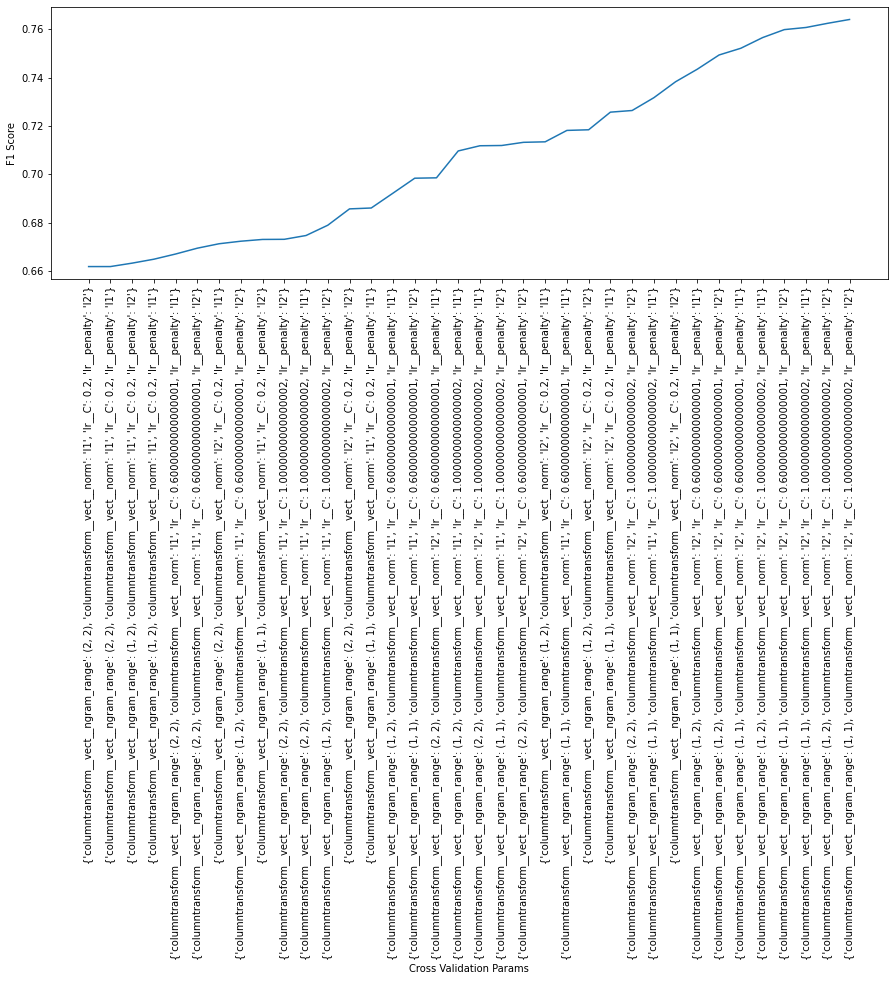

F1_score Best CV Score: 0.7641000913360881
f1_score (Train): 0.815
f1_score (Test): 0.763
[[2057   11  123]
 [ 224   57   79]
 [ 339   19  452]]
              precision    recall  f1-score   support

          -1       0.79      0.94      0.86      2191
           0       0.66      0.16      0.26       360
           1       0.69      0.56      0.62       810

    accuracy                           0.76      3361
   macro avg       0.71      0.55      0.58      3361
weighted avg       0.75      0.76      0.73      3361



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26532\1520051494.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_to_save_df)


In [151]:
# Define pipeline for Logistic Regression (no resampling)
pipe_lr_tfidf = Pipeline([
    ('columntransform', tfidf_coltransformer),
    ('lr', LogisticRegression(random_state=randomseed, max_iter=500, solver='liblinear'))
])

# Define param grid for Logistic Regression
# Logistc regression requires 2 parameters 'C' and 'penalty' to be optimized by gridsearchCV.
# C represents the regularization constant
# penalty represents either l1 - lasso or l2 ridge regression
# Also perform hyper parameter tuning for our tfidfvectorizer within the pipeline for our ngram_range within columntransform object
# [(1, 1), (1, 2), (2, 2)] represents unigram, unigram&bigrams and bigrams only respectively.

lr_tfidf_param = {
    'columntransform__vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'columntransform__vect__norm': ['l1','l2'],
    'lr__C': np.arange(0.2,1.2,0.4),
    'lr__penalty': ['l1','l2']
}

# Train model using the train_model function
lr_tfidf = train_model(X_train, y_train, pipe_lr_tfidf, lr_tfidf_param, f1scorer)

print_results(lr_tfidf, full_data, 'Logistic Regression (tfidf, no resampling)')


<b><u>Results:<b><u>

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'columntransform__vect__ngram_range': (1, 1), 'columntransform__vect__norm': 'l2', 'lr__C': 1.0000000000000002, 'lr__penalty': 'l2'}


F1_score Best CV Score: 0.7641000913360881

f1_score (Train): 0.815

f1_score (Test): 0.763

![CV results for Logistic Regression no resampling](https://raw.githubusercontent.com/garyongjianying/test_repo/main/LR_tfidf_noresample.png?token=GHSAT0AAAAAAB7Z72UV7DU254A4REMOUW7YZAKB6OA)

# Logistic Regression (tfidf, oversample) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'columntransform__vect__ngram_range': (1, 2), 'columntransform__vect__norm': 'l2', 'lr__C': 1.0000000000000002, 'lr__penalty': 'l2'}


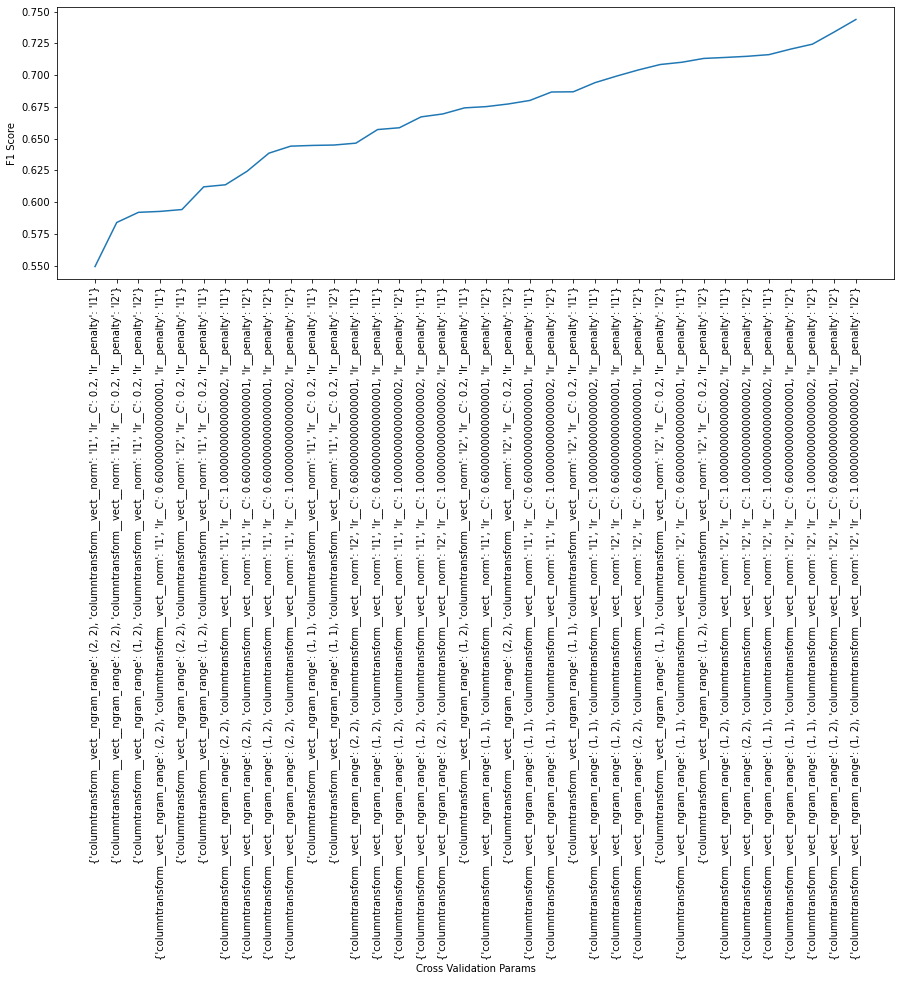

F1_score Best CV Score: 0.7437766259037089
f1_score (Train): 0.919
f1_score (Test): 0.741
[[1744  159  288]
 [  97  171   92]
 [ 139   95  576]]
              precision    recall  f1-score   support

          -1       0.88      0.80      0.84      2191
           0       0.40      0.47      0.44       360
           1       0.60      0.71      0.65       810

    accuracy                           0.74      3361
   macro avg       0.63      0.66      0.64      3361
weighted avg       0.76      0.74      0.75      3361



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26532\1520051494.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_to_save_df)


In [152]:
# Define pipeline for Logistic Regression (no resampling)
pipe_lr_tfidf_OS = Pipeline([
    ('oversample', sampler_OS),
    ('columntransform', tfidf_coltransformer),
    ('lr', LogisticRegression(random_state=randomseed, max_iter=500, solver='liblinear'))
])

# Define param grid for Logistic Regression
# Logistc regression requires 2 parameters 'C' and 'penalty' to be optimized by gridsearchCV.
# C represents the regularization constant
# penalty represents either l1 - lasso or l2 ridge regression
# Also perform hyper parameter tuning for our tfidfvectorizer within the pipeline for our ngram_range within columntransform object
# [(1, 1), (1, 2), (2, 2)] represents unigram, unigram&bigrams and bigrams only respectively.

lr_tfidf_param = {
    'columntransform__vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'columntransform__vect__norm': ['l1','l2'],
    'lr__C': np.arange(0.2,1.2,0.4),
    'lr__penalty': ['l1','l2']
}

# Train model using the train_model function
lr_tfidf_OS = train_model(X_train, y_train, pipe_lr_tfidf_OS, lr_tfidf_param, f1scorer)

print_results(lr_tfidf_OS, full_data, 'Logistic Regression (tfidf, oversample)')


<b><u>Results:<b><u>

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'columntransform__vect__ngram_range': (1, 2), 'columntransform__vect__norm': 'l2', 'lr__C': 1.0000000000000002, 'lr__penalty': 'l2'}

F1_score Best CV Score: 0.7437766259037089

f1_score (Train): 0.919

f1_score (Test): 0.741

![CV results for Logistic Regression w/ Oversample](https://raw.githubusercontent.com/garyongjianying/test_repo/main/LR_tfidf_oversample.png?token=GHSAT0AAAAAAB7Z72UUYIKMEF7NOA5SKMDOZAKB72A)


# Logistic Regression (countvec, no resampling)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'columntransform__vect__analyzer': 'word', 'columntransform__vect__ngram_range': (1, 2), 'lr__C': 0.6000000000000001, 'lr__penalty': 'l2'}


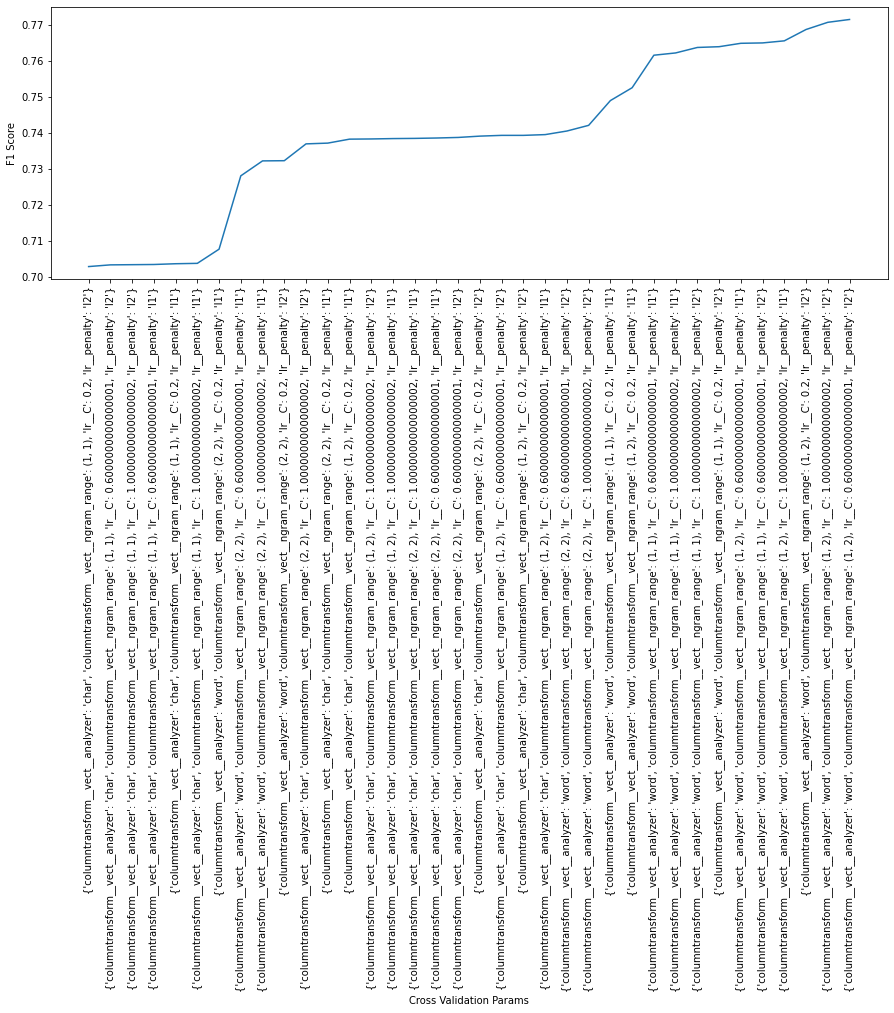

F1_score Best CV Score: 0.7714522741362232
f1_score (Train): 0.979
f1_score (Test): 0.774
[[2034   22  135]
 [ 210   86   64]
 [ 288   40  482]]
              precision    recall  f1-score   support

          -1       0.80      0.93      0.86      2191
           0       0.58      0.24      0.34       360
           1       0.71      0.60      0.65       810

    accuracy                           0.77      3361
   macro avg       0.70      0.59      0.62      3361
weighted avg       0.76      0.77      0.75      3361



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26532\1520051494.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_to_save_df)


In [154]:
# Define pipeline for Logistic Regression (no resampling)
pipe_lr_countvec = Pipeline([
    ('columntransform', countvec_coltransformer),
    ('lr', LogisticRegression(random_state=randomseed, max_iter=500, solver='liblinear'))
])

# Define param grid for Logistic Regression
# Logistc regression requires 2 parameters 'C' and 'penalty' to be optimized by gridsearchCV.
# C represents the regularization constant
# penalty represents either l1 - lasso or l2 ridge regression
# Also perform hyper parameter tuning for our tfidfvectorizer within the pipeline for our ngram_range within columntransform object
# [(1, 1), (1, 2), (2, 2)] represents unigram, unigram&bigrams and bigrams only respectively.

lr_countvec_param = {
    'columntransform__vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'columntransform__vect__analyzer': ['word','char'],
    'lr__C': np.arange(0.2,1.2,0.4),
    'lr__penalty': ['l1','l2']
}

# Train model using the train_model function
lr_countvec = train_model(X_train, y_train, pipe_lr_countvec, lr_countvec_param, f1scorer)

print_results(lr_countvec, full_data, 'Logistic Regression (countvec, no resampling)')


<b><u>Results:<b><u>
    
Fitting 5 folds for each of 36 candidates, totalling 180 fits
    
Best parameters: {'columntransform__vect__analyzer': 'word', 'columntransform__vect__ngram_range': (1, 2), 'lr__C': 0.6000000000000001, 'lr__penalty': 'l2'}    

F1_score Best CV Score: 0.7714522741362232
    
f1_score (Train): 0.979
    
f1_score (Test): 0.774
    
![CV results for Logistic Regression w/ Oversample](https://raw.githubusercontent.com/garyongjianying/test_repo/main/LR_countvec_noresample.png?token=GHSAT0AAAAAAB7Z72UUHRPFP57FS4SU5PXEZAKCFCA)


# Logistic Regression (countvec, oversample)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'columntransform__vect__ngram_range': (1, 2), 'lr__C': 0.6000000000000001, 'lr__penalty': 'l2'}


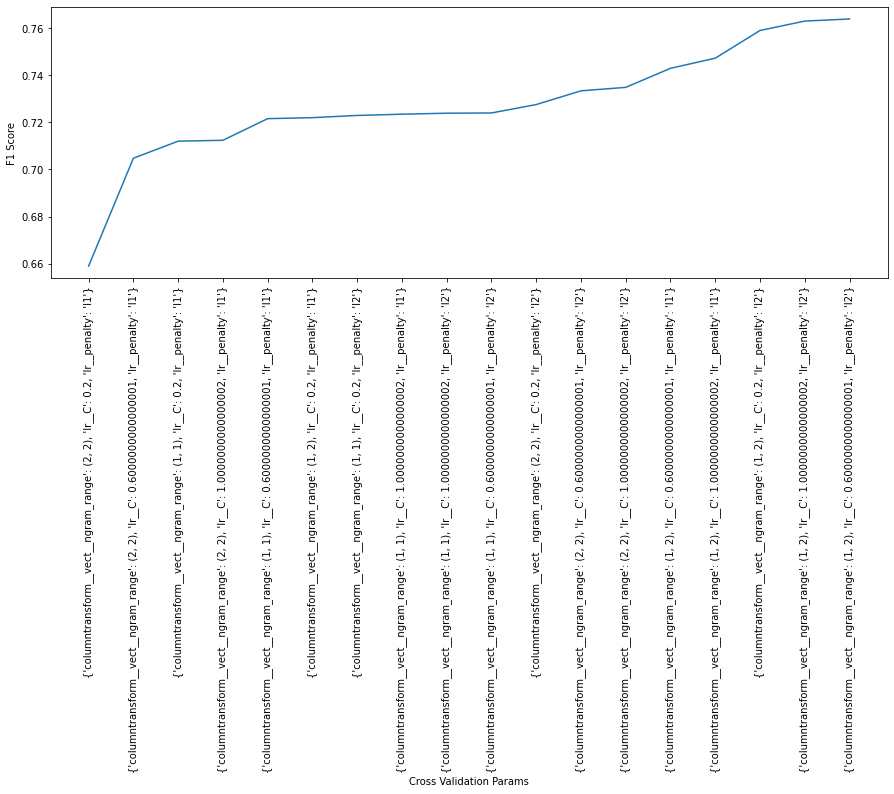

F1_score Best CV Score: 0.7638900486684566
f1_score (Train): 0.993
f1_score (Test): 0.763
[[1893  104  194]
 [ 130  155   75]
 [ 204   89  517]]
              precision    recall  f1-score   support

          -1       0.85      0.86      0.86      2191
           0       0.45      0.43      0.44       360
           1       0.66      0.64      0.65       810

    accuracy                           0.76      3361
   macro avg       0.65      0.64      0.65      3361
weighted avg       0.76      0.76      0.76      3361



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26532\1520051494.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_to_save_df)


In [155]:
# Define pipeline for Logistic Regression (no resampling)
pipe_lr_countvec_OS = Pipeline([
    ('oversample', sampler_OS),
    ('columntransform', countvec_coltransformer),
    ('lr', LogisticRegression(random_state=randomseed, max_iter=500, solver='liblinear'))
])

# Define param grid for Logistic Regression
# Logistc regression requires 2 parameters 'C' and 'penalty' to be optimized by gridsearchCV.
# C represents the regularization constant
# penalty represents either l1 - lasso or l2 ridge regression
# Also perform hyper parameter tuning for our tfidfvectorizer within the pipeline for our ngram_range within columntransform object
# [(1, 1), (1, 2), (2, 2)] represents unigram, unigram&bigrams and bigrams only respectively.

lr_countvec_param = {
    'columntransform__vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    #'columntransform__vect__analyzer': ['word','char'],
    'lr__C': np.arange(0.2,1.2,0.4),
    'lr__penalty': ['l1','l2']
}

# Train model using the train_model function
lr_countvec_OS = train_model(X_train, y_train, pipe_lr_countvec_OS, lr_countvec_param, f1scorer)

print_results(lr_countvec_OS, full_data, 'Logistic Regression (countvec, oversample)')




<b><u>Results:<b><u>
    
Fitting 5 folds for each of 18 candidates, totalling 90 fits
    
Best parameters: {'columntransform__vect__ngram_range': (1, 2), 'lr__C': 0.6000000000000001, 'lr__penalty': 'l2'}
    
F1_score Best CV Score: 0.7638900486684566
    
f1_score (Train): 0.993
    
f1_score (Test): 0.763
    
![CV results for Logistic Regression w/ Oversample](https://raw.githubusercontent.com/garyongjianying/test_repo/main/LR_countvec_oversample.png?token=GHSAT0AAAAAAB7Z72UU3GZAGPYYUY5DEPNGZAKCFWQ)


# Naive Bayes (tfidf) - no resample

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'columntransform__vect__ngram_range': (1, 1), 'columntransform__vect__norm': 'l2', 'nb__alpha': 0.2}


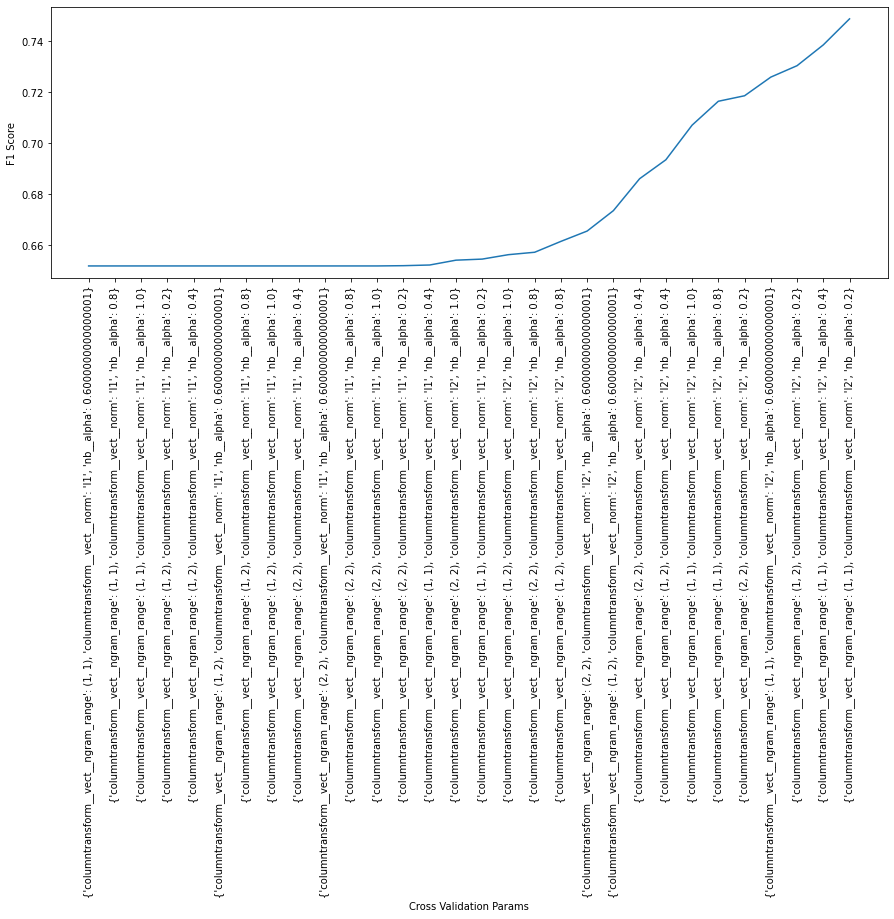

F1_score Best CV Score: 0.7486599903810303
f1_score (Train): 0.830
f1_score (Test): 0.748
[[2088   10   93]
 [ 254   35   71]
 [ 403   16  391]]
              precision    recall  f1-score   support

          -1       0.76      0.95      0.85      2191
           0       0.57      0.10      0.17       360
           1       0.70      0.48      0.57       810

    accuracy                           0.75      3361
   macro avg       0.68      0.51      0.53      3361
weighted avg       0.73      0.75      0.71      3361



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26532\1520051494.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_to_save_df)


In [156]:
# Define pipeline for Logistic Regression (no resampling)
pipe_nb_tfidf = Pipeline([
    ('columntransform', tfidf_coltransformer),
    ('nb', MultinomialNB())
])

# Define param grid for Logistic Regression
# Logistc regression requires 2 parameters 'C' and 'penalty' to be optimized by gridsearchCV.
# C represents the regularization constant
# penalty represents either l1 - lasso or l2 ridge regression
# Also perform hyper parameter tuning for our tfidfvectorizer within the pipeline for our ngram_range within columntransform object
# [(1, 1), (1, 2), (2, 2)] represents unigram, unigram&bigrams and bigrams only respectively.

nb_tfidf_param = {
    'columntransform__vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'columntransform__vect__norm': ['l1','l2'],
    'nb__alpha': np.arange(0.2,1.2,0.2)
}

# Train model using the train_model function
nb_tfidf = train_model(X_train, y_train, pipe_nb_tfidf, nb_tfidf_param, f1scorer)

print_results(nb_tfidf, full_data, 'Naive Bayes (tfidf, no resampling)')


<b><u>Results:<b><u>
    
Fitting 5 folds for each of 30 candidates, totalling 150 fits
    
Best parameters: {'columntransform__vect__ngram_range': (1, 1), 'columntransform__vect__norm': 'l2', 'nb__alpha': 0.2}
    
F1_score Best CV Score: 0.7486599903810303
    
f1_score (Train): 0.830
    
f1_score (Test): 0.748
    
![CV results for Logistic Regression w/ Oversample](https://raw.githubusercontent.com/garyongjianying/test_repo/main/NB_tfidf_noresample.png?token=GHSAT0AAAAAAB7Z72UVUV4FSMWJJBXLRZWWZAKCLMQ)


# Naive Bayes (tfidf) - oversample

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'columntransform__vect__ngram_range': (1, 2), 'columntransform__vect__norm': 'l2', 'nb__alpha': 0.2}


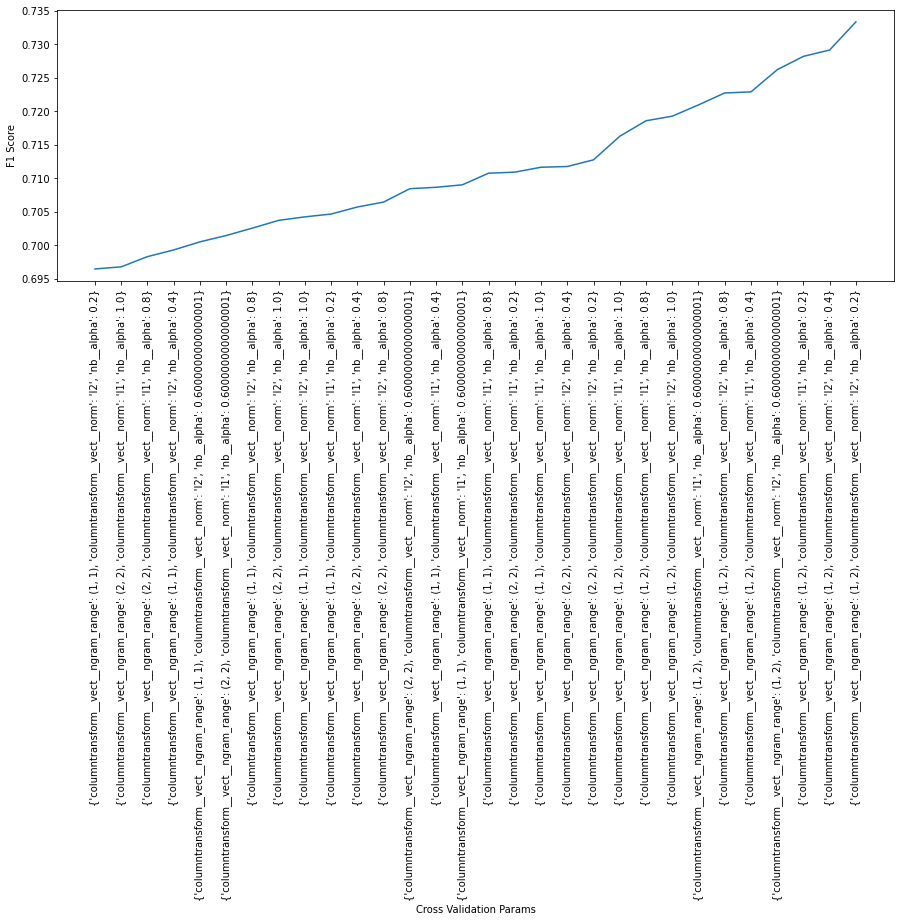

F1_score Best CV Score: 0.7333261172675949
f1_score (Train): 0.967
f1_score (Test): 0.719
[[1744  168  279]
 [ 115  150   95]
 [ 205   84  521]]
              precision    recall  f1-score   support

          -1       0.84      0.80      0.82      2191
           0       0.37      0.42      0.39       360
           1       0.58      0.64      0.61       810

    accuracy                           0.72      3361
   macro avg       0.60      0.62      0.61      3361
weighted avg       0.73      0.72      0.72      3361



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26532\1520051494.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_to_save_df)


In [157]:
# Define pipeline for Logistic Regression (no resampling)
pipe_nb_tfidf_OS = Pipeline([
    ('oversample', sampler_OS),
    ('columntransform', tfidf_coltransformer),
    ('nb', MultinomialNB())
])

# Define param grid for Logistic Regression
# Logistc regression requires 2 parameters 'C' and 'penalty' to be optimized by gridsearchCV.
# C represents the regularization constant
# penalty represents either l1 - lasso or l2 ridge regression
# Also perform hyper parameter tuning for our tfidfvectorizer within the pipeline for our ngram_range within columntransform object
# [(1, 1), (1, 2), (2, 2)] represents unigram, unigram&bigrams and bigrams only respectively.

nb_tfidf_param = {
    'columntransform__vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'columntransform__vect__norm': ['l1','l2'],
    'nb__alpha': np.arange(0.2,1.2,0.2)
}

# Train model using the train_model function
nb_tfidf_OS = train_model(X_train, y_train, pipe_nb_tfidf_OS, nb_tfidf_param, f1scorer)

print_results(nb_tfidf_OS, full_data, 'Naive Bayes (tfidf, oversample)')


<b><u>Results:<b><u>
    
Fitting 5 folds for each of 30 candidates, totalling 150 fits
    
Best parameters: {'columntransform__vect__ngram_range': (1, 2), 'columntransform__vect__norm': 'l2', 'nb__alpha': 0.2}
    
F1_score Best CV Score: 0.7333261172675949
    
f1_score (Train): 0.967
    
f1_score (Test): 0.719
    
![CV results for Logistic Regression w/ Oversample](https://raw.githubusercontent.com/garyongjianying/test_repo/main/NB_tfidf_oversample.png?token=GHSAT0AAAAAAB7Z72UVCRWDIZHCO2FVT2SAZAKCMKQ)


# Naive Bayes (countvec) - no resample

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'columntransform__vect__analyzer': 'word', 'columntransform__vect__ngram_range': (1, 2), 'nb__alpha': 0.4}


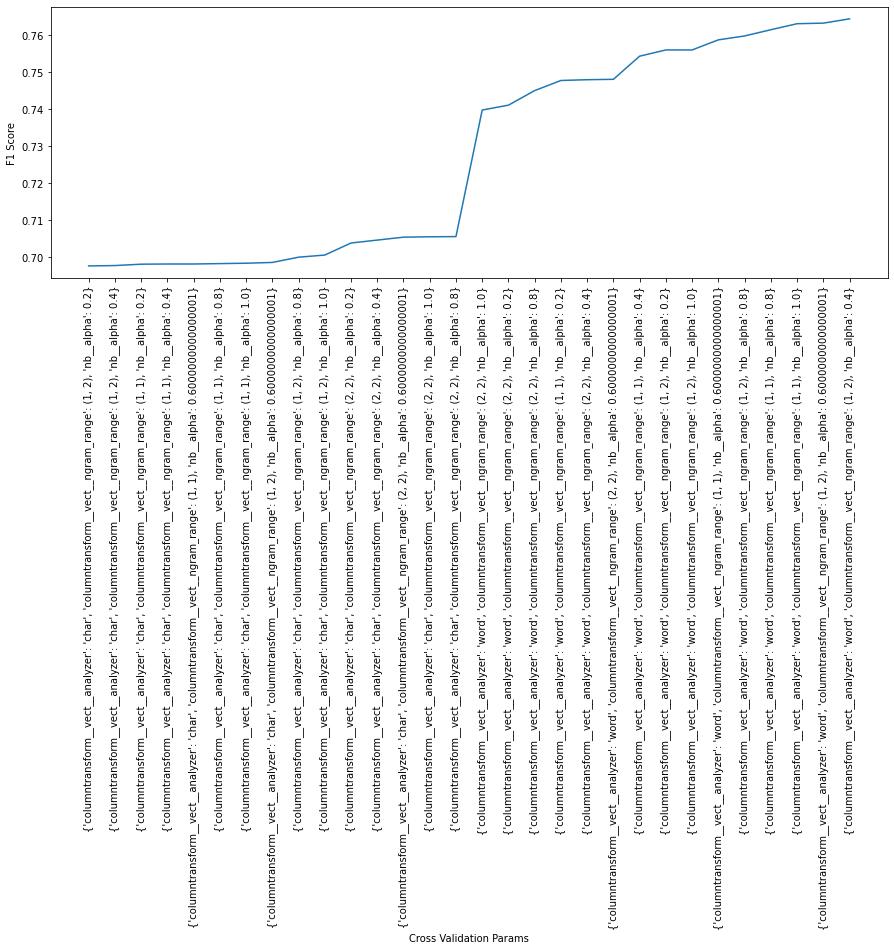

F1_score Best CV Score: 0.7643100374830951
f1_score (Train): 0.953
f1_score (Test): 0.758
[[1965   24  202]
 [ 178   76  106]
 [ 278   24  508]]
              precision    recall  f1-score   support

          -1       0.81      0.90      0.85      2191
           0       0.61      0.21      0.31       360
           1       0.62      0.63      0.62       810

    accuracy                           0.76      3361
   macro avg       0.68      0.58      0.60      3361
weighted avg       0.74      0.76      0.74      3361



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26532\1520051494.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_to_save_df)


In [158]:
# Define pipeline for Logistic Regression (no resampling)
pipe_nb_countvec = Pipeline([
    ('columntransform', countvec_coltransformer),
    ('nb', MultinomialNB())
])

# Define param grid for Logistic Regression
# Logistc regression requires 2 parameters 'C' and 'penalty' to be optimized by gridsearchCV.
# C represents the regularization constant
# penalty represents either l1 - lasso or l2 ridge regression
# Also perform hyper parameter tuning for our tfidfvectorizer within the pipeline for our ngram_range within columntransform object
# [(1, 1), (1, 2), (2, 2)] represents unigram, unigram&bigrams and bigrams only respectively.

nb_countvec_param = {
    'columntransform__vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'columntransform__vect__analyzer': ['word','char'],
    'nb__alpha': np.arange(0.2,1.2,0.2)
}

# Train model using the train_model function
nb_countvec = train_model(X_train, y_train, pipe_nb_countvec, nb_countvec_param, f1scorer)

print_results(nb_countvec, full_data, 'Naive Bayes (countvec, no resampling)')


<b><u>Results:<b><u>
    
Fitting 5 folds for each of 30 candidates, totalling 150 fits
    
Best parameters: {'columntransform__vect__analyzer': 'word', 'columntransform__vect__ngram_range': (1, 2), 'nb__alpha': 0.4}
    
F1_score Best CV Score: 0.7643100374830951
    
f1_score (Train): 0.953
    
f1_score (Test): 0.758
    
![CV results for Logistic Regression w/ Oversample](https://raw.githubusercontent.com/garyongjianying/test_repo/main/NB_countvec_noresample.png?token=GHSAT0AAAAAAB7Z72UV4IZT4AIN2CHXH7W4ZAKCOWQ)


# Naive Bayes (countvec) - oversample

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'columntransform__vect__analyzer': 'word', 'columntransform__vect__ngram_range': (1, 2), 'nb__alpha': 0.2}


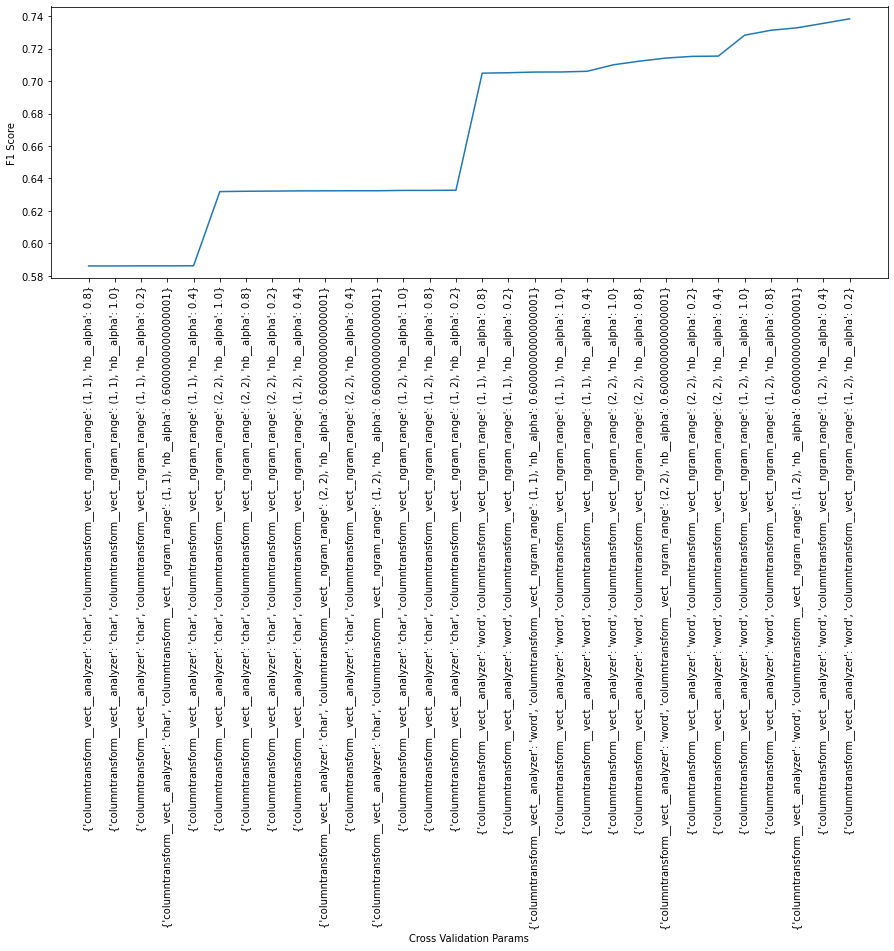

F1_score Best CV Score: 0.7383148409009179
f1_score (Train): 0.967
f1_score (Test): 0.719
[[1782  153  256]
 [ 134  130   96]
 [ 243   61  506]]
              precision    recall  f1-score   support

          -1       0.83      0.81      0.82      2191
           0       0.38      0.36      0.37       360
           1       0.59      0.62      0.61       810

    accuracy                           0.72      3361
   macro avg       0.60      0.60      0.60      3361
weighted avg       0.72      0.72      0.72      3361



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_26532\1520051494.py:70: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(result_to_save_df)


In [159]:
# Define pipeline for Logistic Regression (no resampling)
pipe_nb_countvec_OS = Pipeline([
    ('oversample', sampler_OS),
    ('columntransform', countvec_coltransformer),
    ('nb', MultinomialNB())
])

# Define param grid for Logistic Regression
# Logistc regression requires 2 parameters 'C' and 'penalty' to be optimized by gridsearchCV.
# C represents the regularization constant
# penalty represents either l1 - lasso or l2 ridge regression
# Also perform hyper parameter tuning for our tfidfvectorizer within the pipeline for our ngram_range within columntransform object
# [(1, 1), (1, 2), (2, 2)] represents unigram, unigram&bigrams and bigrams only respectively.

nb_countvec_param = {
    'columntransform__vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'columntransform__vect__analyzer': ['word','char'],
    'nb__alpha': np.arange(0.2,1.2,0.2)
}

# Train model using the train_model function
nb_countvec_OS = train_model(X_train, y_train, pipe_nb_countvec_OS, nb_countvec_param, f1scorer)

print_results(nb_countvec_OS, full_data, 'Naive Bayes (countvec, oversample)')


<b><u>Results:<b><u>
    
Fitting 5 folds for each of 30 candidates, totalling 150 fits
    
Best parameters: {'columntransform__vect__analyzer': 'word', 'columntransform__vect__ngram_range': (1, 2), 'nb__alpha': 0.2}
    
F1_score Best CV Score: 0.7383148409009179
    
f1_score (Train): 0.967
    
f1_score (Test): 0.719
    
![CV results for Logistic Regression w/ Oversample](https://raw.githubusercontent.com/garyongjianying/test_repo/main/NB_countvec_oversample.png?token=GHSAT0AAAAAAB7Z72UUXAWKHQ37AOW3TL66ZAKCRGQ)


# Cross-Validation final results

In [223]:
resultdict_copy = {'Logistic Regression (tfidf, no resampling)': [{'columntransform__vect__ngram_range': (1,
    1),
   'columntransform__vect__norm': 'l2',
   'lr__C': 1.0000000000000002,
   'lr__penalty': 'l2'},
  0.7634632549836359],
 'Logistic Regression (tfidf, oversample)': [{'columntransform__vect__ngram_range': (1,
    2),
   'columntransform__vect__norm': 'l2',
   'lr__C': 1.0000000000000002,
   'lr__penalty': 'l2'},
  0.7411484677179411],
 'Logistic Regression (countvec, no resampling)': [{'columntransform__vect__analyzer': 'word',
   'columntransform__vect__ngram_range': (1, 2),
   'lr__C': 0.6000000000000001,
   'lr__penalty': 'l2'},
  0.7741743528711693],
 'Logistic Regression (countvec, oversample)': [{'columntransform__vect__ngram_range': (1,
    2),
   'lr__C': 0.6000000000000001,
   'lr__penalty': 'l2'},
  0.76316572448676],
 'Naive Bayes (tfidf, no resampling)': [{'columntransform__vect__ngram_range': (1,
    1),
   'columntransform__vect__norm': 'l2',
   'nb__alpha': 0.2},
  0.7479916691460875],
 'Naive Bayes (tfidf, oversample)': [{'columntransform__vect__ngram_range': (1,
    2),
   'columntransform__vect__norm': 'l2',
   'nb__alpha': 0.2},
  0.7185361499553704],
 'Naive Bayes (countvec, no resampling)': [{'columntransform__vect__analyzer': 'word',
   'columntransform__vect__ngram_range': (1, 2),
   'nb__alpha': 0.4},
  0.758405236536745],
 'Naive Bayes (countvec, oversample)': [{'columntransform__vect__analyzer': 'word',
   'columntransform__vect__ngram_range': (1, 2),
   'nb__alpha': 0.2},
  0.7194287414459983]}

In [232]:
sortedresults = sorted([[k,v[0],v[1]] for k, v in resultdict_copy.items()], key = lambda x: x[2], reverse = True)
res = pd.DataFrame(sortedresults, columns = ['Model','Best Params','F1 Score'])

from IPython.core.display import HTML
display(HTML(res.to_html()))

,Model,Best Params,F1 Score
0,"Logistic Regression (countvec, no resampling)","{'columntransform__vect__analyzer': 'word', 'columntransform__vect__ngram_range': (1, 2), 'lr__C': 0.6000000000000001, 'lr__penalty': 'l2'}",0.774174
1,"Logistic Regression (tfidf, no resampling)","{'columntransform__vect__ngram_range': (1, 1), 'columntransform__vect__norm': 'l2', 'lr__C': 1.0000000000000002, 'lr__penalty': 'l2'}",0.763463
2,"Logistic Regression (countvec, oversample)","{'columntransform__vect__ngram_range': (1, 2), 'lr__C': 0.6000000000000001, 'lr__penalty': 'l2'}",0.763166
3,"Naive Bayes (countvec, no resampling)","{'columntransform__vect__analyzer': 'word', 'columntransform__vect__ngram_range': (1, 2), 'nb__alpha': 0.4}",0.758405
4,"Naive Bayes (tfidf, no resampling)","{'columntransform__vect__ngram_range': (1, 1), 'columntransform__vect__norm': 'l2', 'nb__alpha': 0.2}",0.747992
5,"Logistic Regression (tfidf, oversample)","{'columntransform__vect__ngram_range': (1, 2), 'columntransform__vect__norm': 'l2', 'lr__C': 1.0000000000000002, 'lr__penalty': 'l2'}",0.741148
6,"Naive Bayes (countvec, oversample)","{'columntransform__vect__analyzer': 'word', 'columntransform__vect__ngram_range': (1, 2), 'nb__alpha': 0.2}",0.719429
7,"Naive Bayes (tfidf, oversample)","{'columntransform__vect__ngram_range': (1, 2), 'columntransform__vect__norm': 'l2', 'nb__alpha': 0.2}",0.718536


## After testing out the top 4 models with the highest validation f1 score, we proceed to train individual models and upload the respective results to kaggle to get a final f1 score.

The results showed that the best performing model with **highest test f1_score is still Logistic Regression (tfidf, no resampling)**, which achieved a score of 0.85446 test f1_score on kaggle.

# Building a basic multilayer perception
- We will utilize a total of 3 hidden layers (256,128,64 units respectively), 1 input & output layer (3 units).
- Since it is a multiclass problem, we utilize softmax as the activation for the output layer. Relu activation is utilized for the rest of the hidden layers.
- We utilize l2 regularization to prevent overfitting by specifying a kernel regularizer at each layer. We search for the best regularization constant to be used in the GridSearchCV
- KerasClassifer is used as a wrapper for the Sequential model so that it can be used as an estimator and to provides a unified interface for use with GridSearchCV.
- We utilize BatchNormalization layers in between hidden layers to prevent the problem of vanishing gradients and exploding gradients during backpropagation, which can help to speed up training due to similar data scales and improve generalization by reducing overfitting.
- We monitor the validation loss of the neural network training to ensure that there are no overfitting to the training data. To handle this, we utilize EarlyStopping callback with patience of 3.

In [256]:
from keras import backend as K

def batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].toarray()
        y_batch = y_data[y_data.index[index_batch]]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            counter=0
            

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [257]:
# # # 3 layer multi layer perceptron
# def build_fcnn(unit, alpha, input_shape):
#     nn = tf.keras.models.Sequential()
#     nn.add(tf.keras.layers.Dense(units=unit, activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(alpha)))
#     nn.add(tf.keras.layers.BatchNormalization())
#     nn.add(tf.keras.layers.Dense(units=unit, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(alpha)))
#     nn.add(tf.keras.layers.BatchNormalization())
#     nn.add(tf.keras.layers.Dense(units=unit, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(alpha)))
#     nn.add(tf.keras.layers.BatchNormalization())
#     nn.add(tf.keras.layers.Dense(units=1, activation='softmax'))
#     nn.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[lambda y_true, y_pred: f1_score(y_true, y_pred, average='micro')])
#     return nn



In [258]:
test_df

,Sentence_id,Text,Verdict
0,1,"You know, I saw a movie - ""Crocodile Dundee.""",-1
1,2,We're consuming 50 percent of the world's coca...,1
2,3,That answer was about as clear as Boston harbor.,-1
3,4,Let me help the governor.,-1
4,5,We've run up more debt in the last eight years...,1
...,...,...,...
1027,1028,He has promised a trillion dollars out of the ...,1
1028,1029,(LAUGHTER) I -- there's an old high school deb...,-1
1029,1030,"Well, can I answer that?",-1
1030,1031,I look forward to the final weeks of this camp...,-1


In [271]:
sentences_POS_dialog_narrative_ratios, labels_POS_dialog_narrative_ratios = get_sentences_and_label(new_df_POS_dialog_narrative_ratios)

tfidf_vectorizer_POS_dialog_narrative_ratios = TfidfVectorizer(ngram_range=(1,1)) # baseline TfidfVectorizer

# Train model on full training dataset and make an array
X_train_tfidf_POS_dialog_narrative_ratios = tfidf_vectorizer_POS_dialog_narrative_ratios.fit_transform(sentences_POS_dialog_narrative_ratios).toarray() # perform fit_transform

# Get sentences from test data and transform with tfidf and make an array
X_test_tfidf_POS_dialog_narrative_ratios = tfidf_vectorizer_POS_dialog_narrative_ratios.transform(test_df_POS_dialog_narrative_ratios['Text']).toarray()

# Convert the above list to a DataFrame
train_tfidf = pd.DataFrame(X_train_tfidf_POS_dialog_narrative_ratios)
train_tfidf.reset_index(inplace=True, drop=True)
test_tfidf = pd.DataFrame(X_test_tfidf_POS_dialog_narrative_ratios)
test_tfidf.reset_index(inplace=True, drop=True)

# Combine POS and dialog_narrative columns into one list so that we can extract them.
# combined columns now is represented by:
print(combined_cols_v2)

train_POS_dialog_narrative_ratios_feature = new_df_POS_dialog_narrative_ratios[combined_cols_v2]
train_POS_dialog_narrative_ratios_feature.reset_index(inplace=True, drop=True)
test_POS_dialog_narrative_ratios_feature = test_df_POS_dialog_narrative_ratios[combined_cols_v2]
test_POS_dialog_narrative_ratios_feature.reset_index(inplace=True,drop=True)

# Merge the tfidf feature and subj feature, using a left join
X_train = pd.merge(train_tfidf, train_POS_dialog_narrative_ratios_feature, left_index=True, right_index=True)
X_test = pd.merge(test_tfidf, test_POS_dialog_narrative_ratios_feature,left_index=True, right_index=True)


# MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
sc = MinMaxScaler()

# Perform normalization
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# convert for proper usecase for MLP
y_train = tf.keras.utils.to_categorical(labels_POS_dialog_narrative_ratios, num_classes=3)

['nn_count', 'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count', 'num_dialog', 'num_narrative', 'unique_vs_words', 'stopwords_vs_words']


C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Gary2\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


# Defining our MLP

In [288]:
# Define shallow FCNN with 3 hidden layers, and 1 input and output layer. softmax with 3 classes
model = Sequential()
# model.add(Flatten(input_dim=X_train_scaled.shape[1])) # input layer
# model.add(input_dim=X_train_scaled.shape[1]) # input layer
model.add(Dense(256, activation='relu', input_dim=X_train_scaled.shape[1], kernel_regularizer=tf.keras.regularizers.l2(0.05)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.05)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.51)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(3, activation='softmax')) # output layer with 3 classes
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=[f1_m])
# model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), metrics=[f1_m])

In [290]:
# Define EarlyStopping call back, when the monitored metric has stopped improving significantly.
# call back stops training when there is no improvement in loss for 3 consecutive epochs.
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# mycallback = [
#     keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
# ]

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 256)               2927360   
                                                                 
 batch_normalization_22 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_35 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_23 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_24 (Bat  (None, 64)              

Epoch 1/30
596/596 - 28s - loss: 7.6982 - f1_m: 0.6916 - val_loss: 1.4755 - val_f1_m: 0.6424 - 28s/epoch - 48ms/step
Epoch 2/30
596/596 - 23s - loss: 1.1953 - f1_m: 0.7282 - val_loss: 1.2998 - val_f1_m: 0.6904 - 23s/epoch - 38ms/step
Epoch 3/30
596/596 - 23s - loss: 1.0276 - f1_m: 0.7414 - val_loss: 1.0415 - val_f1_m: 0.7057 - 23s/epoch - 38ms/step
Epoch 4/30
596/596 - 24s - loss: 0.9327 - f1_m: 0.7526 - val_loss: 1.0515 - val_f1_m: 0.6627 - 24s/epoch - 41ms/step
Epoch 5/30
596/596 - 23s - loss: 0.8443 - f1_m: 0.7658 - val_loss: 0.8671 - val_f1_m: 0.7234 - 23s/epoch - 38ms/step
Epoch 6/30
596/596 - 24s - loss: 0.7976 - f1_m: 0.7705 - val_loss: 0.8789 - val_f1_m: 0.7235 - 24s/epoch - 40ms/step
Epoch 7/30
596/596 - 23s - loss: 0.7615 - f1_m: 0.7748 - val_loss: 0.9745 - val_f1_m: 0.6652 - 23s/epoch - 39ms/step
Epoch 8/30
596/596 - 26s - loss: 0.7273 - f1_m: 0.7808 - val_loss: 0.8589 - val_f1_m: 0.7132 - 26s/epoch - 44ms/step
Epoch 9/30
596/596 - 24s - loss: 0.7014 - f1_m: 0.7856 - val_los

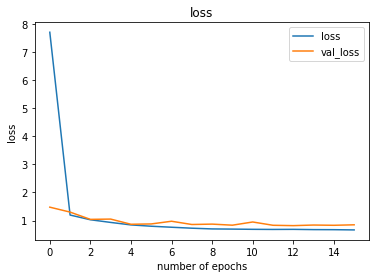

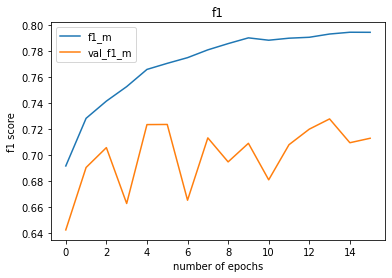

In [291]:
# fit our MLP
history = model.fit(x=X_train_scaled,
                   y=y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.15,
                    verbose=2,
                    callbacks=[callback]
                   )



history_df = pd.DataFrame(history.history)

ax1 = history_df.plot(y=['loss','val_loss'], title='loss')
ax1.set_xlabel('number of epochs')
ax1.set_ylabel('loss')
ax1.locator_params(integer=True)
ax2 = history_df.plot(y=['f1_m','val_f1_m'], title='f1')
ax2.set_xlabel('number of epochs')
ax2.set_ylabel('f1 score')
ax2.locator_params(integer=True)


# Use our FCNN model to do predictions on X_test_scaled

In [307]:
val_f1_per_epoch = history.history['val_f1_m']
best_epoch = val_f1_per_epoch.index(max(val_f1_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')
print(f'Highest f1_m score: {max(val_f1_per_epoch):.3f}')


# Evaluate results on X_test_scaled
y_pred_full = model.predict(X_test_scaled)

y_pred_results = y_pred_full.argmax(axis=1) - 1 # convert from 0,1,2 to -1,0,1


# # Do predictions on X_test_scaled
# y_pred_full = LR_classifier_POS_dialog_narrative_ratios.predict(X_test_scaled)

# Generate the csv file to submit to kaggle
generate_result(test_df_POS_dialog_narrative_ratios.drop(columns=combined_cols_v2), y_pred_results, filename)

Best epoch: 14
Highest f1_m score: 0.728
33/33 [==============================] - 3s 4ms/step


### From kaggle, the results for 3 layer Multilayer Perceptron for test f1_score stands at 0.67184, showing that the FCNN is not optimal currently and more hyperparameter tuning has to be performed for better results.

In [1]:
# sentences_POS_dialog_narrative_ratios, labels_POS_dialog_narrative_ratios = get_sentences_and_label(new_df_POS_dialog_narrative_ratios)

# tfidf_vectorizer_POS_dialog_narrative_ratios = CountVectorizer(ngram_range=(1,2)) # baseline TfidfVectorizer

# # Train model on full training dataset and make an array
# X_train_tfidf_POS_dialog_narrative_ratios = tfidf_vectorizer_POS_dialog_narrative_ratios.fit_transform(sentences_POS_dialog_narrative_ratios).toarray() # perform fit_transform

# # Get sentences from test data and transform with tfidf and make an array
# X_test_tfidf_POS_dialog_narrative_ratios = tfidf_vectorizer_POS_dialog_narrative_ratios.transform(test_df_POS_dialog_narrative_ratios['Text']).toarray()

# # Convert the above list to a DataFrame
# train_tfidf = pd.DataFrame(X_train_tfidf_POS_dialog_narrative_ratios)
# train_tfidf.reset_index(inplace=True, drop=True)
# test_tfidf = pd.DataFrame(X_test_tfidf_POS_dialog_narrative_ratios)
# test_tfidf.reset_index(inplace=True, drop=True)

# # Combine POS and dialog_narrative columns into one list so that we can extract them.
# # combined columns now is represented by:
# print(combined_cols_v2)

# train_POS_dialog_narrative_ratios_feature = new_df_POS_dialog_narrative_ratios[combined_cols_v2]
# train_POS_dialog_narrative_ratios_feature.reset_index(inplace=True, drop=True)
# test_POS_dialog_narrative_ratios_feature = test_df_POS_dialog_narrative_ratios[combined_cols_v2]
# test_POS_dialog_narrative_ratios_feature.reset_index(inplace=True,drop=True)

# # Merge the tfidf feature and subj feature, using a left join
# X_train = pd.merge(train_tfidf, train_POS_dialog_narrative_ratios_feature, left_index=True, right_index=True)
# X_test = pd.merge(test_tfidf, test_POS_dialog_narrative_ratios_feature,left_index=True, right_index=True)


# # MinMaxScaler for normalization for combined features of tfidf and subjectivity data.
# sc = MinMaxScaler()

# # Perform normalization
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)

# # Train Logistic Regression classifier with data
# LR_classifier_POS_dialog_narrative_ratios = LogisticRegression(random_state=randomseed, solver='liblinear', C=0.6, penalty='l2').fit(X_train_scaled, labels_POS_dialog_narrative_ratios)

# # Do predictions on X_test_scaled
# y_pred_full = LR_classifier_POS_dialog_narrative_ratios.predict(X_test_scaled)

# # Generate the csv file to submit to kaggle
# generate_result(test_df_POS_dialog_narrative_ratios.drop(columns=combined_cols_v2), y_pred_full, filename)

# END